In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"


import torch, gzip
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable
import _pickle as pickle
from torch.utils.data import TensorDataset, DataLoader

dtype=torch.cuda.FloatTensor
import matplotlib.pyplot as plt

import librosa
import librosa.display

import torch.nn.utils.rnn as rnn
import time
import IPython.display as ipd

%matplotlib notebook

import torchaudio


In [3]:
# Global variables
GV_FRAMESIZE=4096
GV_HOPSIZE=4096
GV_OUTFRAMESIZE=256
# assert GV_FRAMESIZE%GV_HOPSIZE == 0
GV_WIN=np.hanning(GV_FRAMESIZE)
GV_BS=5
GV_SCALE=100.
GV_EPS=1e-20

## Data Prep

In [4]:
timitTrPath='/media/sdc1/Data/timit-wav/train'
timitTePath='/media/sdc1/Data/timit-wav/test'
allTrSpkrPath=[]
allTeSpkrPath=[]
for dr in range(8):
    rootPath=timitTrPath+'/dr{}'.format(dr+1)
    allTrSpkrPath+= [os.path.join(rootPath,spkr) for spkr in os.listdir(rootPath) if os.path.isdir(os.path.join(rootPath, spkr))]
    rootPath=timitTePath+'/dr{}'.format(dr+1)
    allTeSpkrPath+= [os.path.join(rootPath,spkr) for spkr in os.listdir(rootPath) if os.path.isdir(os.path.join(rootPath, spkr))]

In [5]:
# choose 12 random spkrs for training; 4 for evaluation; 4 for testing
np.random.seed(0)
trSpkrIdx=np.random.permutation(len(allTrSpkrPath))[:50]
# vSpkrIdx=np.random.permutation(len(allTrSpkrPath))[20:30]
teSpkrIdx=np.random.permutation(len(allTeSpkrPath))[:10]
print(trSpkrIdx, teSpkrIdx)

[113  21  78 118 225 423 375  71  90 352 124 100 336 393 154 175 318  12
 303 427 276 250 164 107 361 239  10  15 344 155 365 390 295   1 300 431
 425 342 353 194 221 157 283 417  54 301 219 345  37 179] [106 165  78  92 114  39  49  58  52 147]


In [6]:
# collect paths to all the utterances
np.random.seed(0)
trUttPaths=[]
for i in trSpkrIdx:
    for uttFiles in os.listdir(allTrSpkrPath[i]):
        if uttFiles.endswith('.wav'):
            trUttPaths+=[os.path.join(allTrSpkrPath[i],uttFiles)]
# vUttPaths=[]
# for i in vSpkrIdx:
#     for uttFiles in os.listdir(allTrSpkrPath[i]):
#         if uttFiles.endswith('.wav'):
#             vUttPaths+=[os.path.join(allTrSpkrPath[i],uttFiles)]
teUttPaths=[]
for i in teSpkrIdx:
    for uttFiles in os.listdir(allTeSpkrPath[i]):
        if uttFiles.endswith('.wav'):
            teUttPaths+=[os.path.join(allTeSpkrPath[i],uttFiles)]

# collect noise            
noisePaths=[]
rootPath='/media/sdc1/Data/Duan'
noisePaths+=[os.path.join(rootPath, noise) for noise in os.listdir(rootPath) if noise.endswith('.wav')]
            
# print(len(trUttPaths),trUttPaths)
# print(len(vUttPaths),vUttPaths)
# print(len(teUttPaths),teUttPaths)
# print(noisePaths)

# divide noise signal into training and testing parts
trnRaw, tenRaw=[], []
for path in noisePaths:
    n, sr=librosa.load(path, sr=None)
    trnRaw.append(n[:-np.int(len(n)*.25)])
    tenRaw.append(n[-np.int(len(n)*.25):])

# mix up the signals    
trn, trs, trx=[], [], []
for path in trUttPaths:
    for i in range(10):
        s, sr=librosa.load(path, sr=None) # saving redundantly many speech sources (easier to handle)
        trs.append(s/np.std(s))
        startIdx=np.random.randint(len(trnRaw[i])-len(s))
        trn.append(trnRaw[i][startIdx:startIdx+len(s)].copy())
        trn[-1]/=np.std(trn[-1])
        trx.append(trs[-1]+trn[-1])
ten, tes, tex=[], [], []
for path in teUttPaths:
    for i in range(10):
        s, sr=librosa.load(path, sr=None) # saving redundantly many speech sources (easier to handle)
        tes.append(s/np.std(s))
        startIdx=np.random.randint(len(tenRaw[i])-len(s))
        ten.append(tenRaw[i][startIdx:startIdx+len(s)].copy())
        ten[-1]/=np.std(ten[-1])
        tex.append(tes[-1]+ten[-1])
# vn, vs, vx=[], [], []
# for path in trUttPaths:
#     for i in range(10):
#         s, sr=librosa.load(path, sr=None) # saving redundantly many speech sources (easier to handle)
#         vs.append(s/np.std(s))
#         startIdx=np.random.randint(len(trnRaw[i])-len(s))
#         vn.append(trnRaw[i][startIdx:startIdx+len(s)])
#         vn[-1]/=np.std(vn[-1])
#         vx.append(vs[-1]+vn[-1])

        

In [7]:
# taking care of the normalization (by dividing by the largest amplitude in the entire collection)
maxAmp=0
for signal in trx:
    if np.max(np.abs(signal))>maxAmp:
        maxAmp=np.max(np.abs(signal))
    
maxAmp*=1.5
# print(maxAmp)
trs/=maxAmp
trn/=maxAmp
trx/=maxAmp
tes/=maxAmp
ten/=maxAmp
tex/=maxAmp
# vs/=maxAmp
# vn/=maxAmp
# vx/=maxAmp



## Reshape signals into matrices (# of frames) X (frame size)

In [8]:
def SDR(s,sr):
    eps=1e-20
    ml=np.minimum(len(s), len(sr))
    s=s[:ml]
    sr=sr[:ml]
    return ml, 10*np.log10(np.sum(s**2)/(np.sum((s-sr)**2)+eps)+eps)

In [9]:
def vec2mat(x, win):
    nFrPad=np.int(GV_FRAMESIZE/GV_HOPSIZE)
    if x.shape[0]%GV_HOPSIZE>0:
        x=np.concatenate( (x, np.zeros(GV_HOPSIZE-x.shape[0]%GV_HOPSIZE)), axis=0)
    x=np.concatenate( (np.zeros((nFrPad-1)*GV_HOPSIZE), x), axis=0)
    x=np.concatenate( (x, np.zeros((nFrPad-1)*GV_HOPSIZE)), axis=0)    
    y=np.zeros((np.int((x.shape[0]-GV_FRAMESIZE)/GV_HOPSIZE+1), GV_FRAMESIZE))
    for ii in range(0,x.shape[0]-GV_FRAMESIZE,GV_HOPSIZE):
        y[np.int(ii/GV_HOPSIZE),:]=x[ii:ii+GV_FRAMESIZE]
    if len(win)==0:        
        return y
    else:
        return y*np.reshape(win, (1,GV_FRAMESIZE))

In [10]:
def mat2vec(x, win):
    N=x.shape[0]
    M=x.shape[1]
    nFrPad=np.int(M/GV_HOPSIZE)
    y = np.zeros(GV_HOPSIZE*(N-1)+M)
    if len(win)==0:
        for ii in range(N):
            y[ii*GV_HOPSIZE:ii*GV_HOPSIZE+M]+=x[ii,:]
    else:
        for ii in range(N):
            y[ii*GV_HOPSIZE:ii*GV_HOPSIZE+M]+=x[ii,:]*win
    y = y[(nFrPad-1)*GV_HOPSIZE:-(nFrPad-1)*GV_HOPSIZE-1]
    return y/(nFrPad/2)

In [11]:
trS, trN, trX, vS, vN, vX, teS, teN, teX=[],[],[],[],[],[],[],[],[]
for signal in trs:
    trS.append(vec2mat(signal, []))
    trS[-1]=trS[-1][:,-GV_OUTFRAMESIZE*2:].copy()
    trS[-1]*=np.reshape(np.hanning(2*GV_OUTFRAMESIZE), (1, 2*GV_OUTFRAMESIZE))
# for signal in trn:
#     trN.append(vec2mat(signal, []))
for signal in trx:
    trX.append(vec2mat(signal, []))
# for signal in tes:
#     teS.append(vec2mat(signal, []))
# for signal in ten:
#     teN.append(vec2mat(signal, []))
# for signal in tex:
#     teX.append(vec2mat(signal, []))

In [11]:
# sss=mat2vec(trS[0], GV_WIN)
# SDR(sss,trs[0])


In [12]:
class SS1dCNN_Dilated_ResNet(nn.Module):
    def __init__(self, H, K):
        super().__init__()
        self.K=K
        self.H=H  
#         padSize=np.int(np.floor(K/2))
        self.dilation_rates = np.array([1,2,4,8,16,32,64,128,256,512,1024])

        self.conv0 = nn.Conv1d(in_channels=1, out_channels=H, kernel_size=K, dilation=self.dilation_rates[0])
        self.conv1 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, dilation=self.dilation_rates[1])
        self.conv2 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, dilation=self.dilation_rates[2])
        self.conv3 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, dilation=self.dilation_rates[3])
        self.conv4 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, dilation=self.dilation_rates[4])
        self.conv5 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, dilation=self.dilation_rates[5])        
        self.conv6 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, dilation=self.dilation_rates[6])
        self.conv7 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, dilation=self.dilation_rates[7])
        self.conv8 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, dilation=self.dilation_rates[8])
        self.conv9 = nn.Conv1d(in_channels=H, out_channels=1, kernel_size=K, dilation=self.dilation_rates[9])
#         self.conv10 = nn.Conv1d(in_channels=H, out_channels=1, kernel_size=K, dilation=self.dilation_rates[10])
        
        nn.init.kaiming_normal_(self.conv0.weight)
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.kaiming_normal_(self.conv3.weight)
        nn.init.kaiming_normal_(self.conv4.weight)
        nn.init.kaiming_normal_(self.conv5.weight)
        nn.init.kaiming_normal_(self.conv6.weight)
        nn.init.kaiming_normal_(self.conv7.weight)
        nn.init.kaiming_normal_(self.conv8.weight)
        nn.init.kaiming_normal_(self.conv9.weight)
#         nn.init.kaiming_normal_(self.conv10.weight)

    def forward(self, h0):    
        h0=F.relu(self.conv0(h0))
        h0=F.relu(self.conv1(h0))+h0[:,:,self.dilation_rates[1]:-self.dilation_rates[1]]
        h0=F.relu(self.conv2(h0))+h0[:,:,self.dilation_rates[2]:-self.dilation_rates[2]]
        h0=F.relu(self.conv3(h0))+h0[:,:,self.dilation_rates[3]:-self.dilation_rates[3]]
        h0=F.relu(self.conv4(h0))+h0[:,:,self.dilation_rates[4]:-self.dilation_rates[4]]
        h0=F.relu(self.conv5(h0))+h0[:,:,self.dilation_rates[5]:-self.dilation_rates[5]]
        h0=F.relu(self.conv6(h0))+h0[:,:,self.dilation_rates[6]:-self.dilation_rates[6]]
        h0=F.relu(self.conv7(h0))+h0[:,:,self.dilation_rates[7]:-self.dilation_rates[7]]
        h0=F.relu(self.conv8(h0))+h0[:,:,self.dilation_rates[8]:-self.dilation_rates[8]]
        o=F.relu(self.conv9(h0))

        return o        
        

In [15]:
## Doesn't work. Need to rewrite

# def SS1dCNN_test_SDR(model):
#     model.eval()
#     ml=np.zeros(len(tex))
#     SDRlist=np.zeros(len(tex))
#     for i in range(0,len(teX),GV_BS):
#         mb=Variable(torch.cuda.FloatTensor(np.array(teX[i:i+GV_BS])).view(-1,1,GV_FRAMESIZE), requires_grad=False)
# #         mbY=Variable(torch.cuda.FloatTensor(np.array(teS[i:i+GV_BS])).view(-1,1,GV_FRAMESIZE), requires_grad=False)
#         teYh=model(GV_SCALE*mb)
#         teSR=teYh.view(-1,GV_FRAMESIZE).data.cpu().numpy()/GV_SCALE
#         bFr=0
#         for j in range(GV_BS):
#             nFr=teX[i+j].shape[0]
#             tesr=mat2vec(teSR[bFr:bFr+nFr], GV_WIN)
#             bFr+=nFr
#             ml[i+j], SDRlist[i+j]=SDR(tes[i+j], tesr)
        
#     return np.sum(ml*SDRlist/np.sum(ml))



In [21]:
H=20
K=3
# nL=2
lambdaMel=1e-9
# model=SS1dCNN_DenseBlock2(H, Kl, Ks).cuda()
# model=SS1dCNN_ResNet_Block(H, H2, Kl).cuda()
model=SS1dCNN_Dilated_ResNet(H, K).cuda()
optimizer= torch.optim.Adam(model.parameters(), lr=0.001)#, betas=[0.9, 0.999])
maxEpoch=200
errtMel=np.zeros(maxEpoch, dtype=np.float32)
errtMSE=np.zeros(maxEpoch, dtype=np.float32)

mel128=torchaudio.transforms.MelSpectrogram(
            n_fft=GV_OUTFRAMESIZE*2, hop_length=GV_OUTFRAMESIZE*2, n_mels=128).cuda()
mel64=torchaudio.transforms.MelSpectrogram(
            n_fft=GV_OUTFRAMESIZE*2, hop_length=GV_OUTFRAMESIZE*2, n_mels=64).cuda()
mel32=torchaudio.transforms.MelSpectrogram(
            n_fft=GV_OUTFRAMESIZE*2, hop_length=GV_OUTFRAMESIZE*2, n_mels=32).cuda()
mel16=torchaudio.transforms.MelSpectrogram(
            n_fft=GV_OUTFRAMESIZE*2, hop_length=GV_OUTFRAMESIZE*2, n_mels=16).cuda()

for epoch in range(maxEpoch):
    tic=time.time()
    model.train()
    for i in range(0,len(trX), GV_BS):
#         print(np.array(trX[i:i+GV_BS]).shape, np.array(trS[i:i+GV_BS]).shape)
        mb=torch.cuda.FloatTensor(np.array(trX[i:i+GV_BS])).view(-1,1,GV_FRAMESIZE)
        mbY=torch.cuda.FloatTensor(np.array(trS[i:i+GV_BS])).view(-1,1,GV_OUTFRAMESIZE*2)
#         print(mb.shape)
#         print(mbY.shape)
        trYh=model(GV_SCALE*mb)
#         print(trYh.shape, mb.shape, mbY.shape)
#         print(trYh[:,:,-GV_OUTFRAMESIZE*2:].shape, mbY.shape)
        
        errMel=lambdaMel*torch.sum((mel16(trYh[:,:,-GV_OUTFRAMESIZE*2:].flatten())-mel16(GV_SCALE*mbY.flatten()))**2)
        errMel+=lambdaMel*torch.sum((mel16(trYh[:,:,-GV_OUTFRAMESIZE*2:].flatten())-mel16(GV_SCALE*mbY.flatten()))**2)
        errMel+=lambdaMel*torch.sum((mel16(trYh[:,:,-GV_OUTFRAMESIZE*2:].flatten())-mel16(GV_SCALE*mbY.flatten()))**2)
        errMel+=lambdaMel*torch.sum((mel16(trYh[:,:,-GV_OUTFRAMESIZE*2:].flatten())-mel16(GV_SCALE*mbY.flatten()))**2)
    
        errMSE=torch.sum((GV_SCALE*mbY-trYh[:,:,-GV_OUTFRAMESIZE*2:])**2) # MSE
        errtMel[epoch]+=errMel.data.cpu().numpy()
        errtMSE[epoch]+=errMSE.data.cpu().numpy()
        err = errMel+errMSE
        optimizer.zero_grad()
        err.backward()
        optimizer.step()
#     SDRtest=SS1dCNN_test_SDR(model)
    toc=time.time()    
    print('ep: {}\t tictock: {:0.2f} \ttrain error MSE: {} \ttrain error Mel: {}'.format(
        epoch, toc-tic, errtMSE[epoch], errtMel[epoch]))


ep: 0	 tictock: 53.06 	train error MSE: 177164912.0 	train error Mel: 463788544.0
ep: 1	 tictock: 52.83 	train error MSE: 10829336.0 	train error Mel: 182010.234375
ep: 2	 tictock: 52.97 	train error MSE: 10216555.0 	train error Mel: 26855.525390625
ep: 3	 tictock: 52.80 	train error MSE: 10051541.0 	train error Mel: 6908.61669921875
ep: 4	 tictock: 53.06 	train error MSE: 9997487.0 	train error Mel: 2711.185791015625
ep: 5	 tictock: 52.95 	train error MSE: 9976061.0 	train error Mel: 1714.779541015625


KeyboardInterrupt: 

In [17]:
xxx=np.array([[[1,2,3,4]], [[5,6,7,8]]])
print(torch.cuda.FloatTensor(xxx).flatten())

tensor([1., 2., 3., 4., 5., 6., 7., 8.], device='cuda:0')


In [2]:
H=30
H2=10
Kl=15

ResNet bottleneck 20 with BN

ep: 0	 tictock: 500.68 	train error: 86857816.0	 test SDR: 6.7344766903264155
ep: 1	 tictock: 500.71 	train error: 57199340.0	 test SDR: 7.417573972939753
ep: 2	 tictock: 500.66 	train error: 50818652.0	 test SDR: 7.897494617640662
ep: 3	 tictock: 500.40 	train error: 46824776.0	 test SDR: 8.388561783267617
ep: 4	 tictock: 500.63 	train error: 44198228.0	 test SDR: 8.5903875801252
ep: 5	 tictock: 500.16 	train error: 42178536.0	 test SDR: 8.866972188781885
ep: 6	 tictock: 500.06 	train error: 40555440.0	 test SDR: 9.06093442587898
ep: 7	 tictock: 499.93 	train error: 39231040.0	 test SDR: 9.244546793558841
ep: 8	 tictock: 522.38 	train error: 38118104.0	 test SDR: 9.354294762326326
ep: 9	 tictock: 513.21 	train error: 37203196.0	 test SDR: 9.45009777604511
ep: 10	 tictock: 500.93 	train error: 36429624.0	 test SDR: 9.473886851792159
ep: 11	 tictock: 499.93 	train error: 35752460.0	 test SDR: 9.551005257023563
ep: 12	 tictock: 500.01 	train error: 35127508.0	 test SDR: 9.648423649183405
ep: 13	 tictock: 499.76 	train error: 34556864.0	 test SDR: 9.723365731135857
ep: 14	 tictock: 499.87 	train error: 34086740.0	 test SDR: 9.771553715113955
ep: 15	 tictock: 500.19 	train error: 33673180.0	 test SDR: 9.829094566926976
ep: 16	 tictock: 500.18 	train error: 33313978.0	 test SDR: 9.84795533115279
ep: 17	 tictock: 499.97 	train error: 32991754.0	 test SDR: 9.87386663541491
ep: 18	 tictock: 500.02 	train error: 32708030.0	 test SDR: 9.889370782739878
ep: 19	 tictock: 500.15 	train error: 32438788.0	 test SDR: 9.88603967929317
ep: 20	 tictock: 500.25 	train error: 32186346.0	 test SDR: 9.903021653915367
ep: 21	 tictock: 499.99 	train error: 31955958.0	 test SDR: 9.924554273340046
ep: 22	 tictock: 499.94 	train error: 31747300.0	 test SDR: 9.925346087311656
ep: 23	 tictock: 499.89 	train error: 31546598.0	 test SDR: 9.928716069905143
ep: 24	 tictock: 499.98 	train error: 31353876.0	 test SDR: 9.91594510114059
ep: 25	 tictock: 499.84 	train error: 31182050.0	 test SDR: 9.940353675740933
ep: 26	 tictock: 500.30 	train error: 31013510.0	 test SDR: 9.958782140515993
ep: 27	 tictock: 499.97 	train error: 30858226.0	 test SDR: 9.94533971902014
ep: 28	 tictock: 499.95 	train error: 30717258.0	 test SDR: 9.960497164796642
ep: 29	 tictock: 500.13 	train error: 30582590.0	 test SDR: 9.967604722534528
ep: 30	 tictock: 500.31 	train error: 30453142.0	 test SDR: 9.957707076992065
ep: 31	 tictock: 499.92 	train error: 30332002.0	 test SDR: 9.946473682650247
ep: 32	 tictock: 499.93 	train error: 30217936.0	 test SDR: 9.993138778231117
ep: 33	 tictock: 499.69 	train error: 30109224.0	 test SDR: 9.947198645061938
ep: 34	 tictock: 499.88 	train error: 30005936.0	 test SDR: 9.923866236755467
ep: 35	 tictock: 505.00 	train error: 29904750.0	 test SDR: 9.907615799304764
ep: 36	 tictock: 556.72 	train error: 29808842.0	 test SDR: 9.924003851803793
ep: 37	 tictock: 501.77 	train error: 29714826.0	 test SDR: 9.94328773094955

SyntaxError: invalid syntax (<ipython-input-2-0395446cff41>, line 5)

In [ ]:
H=20
H2=10
Kl=15

ResNet bottleneck 20 with BN

ep: 0	 tictock: 387.70 	train error: 80383672.0	 test SDR: 7.247197845308149
ep: 1	 tictock: 387.44 	train error: 54713892.0	 test SDR: 7.86514140509297
ep: 2	 tictock: 387.51 	train error: 49274760.0	 test SDR: 8.075552890383083
ep: 3	 tictock: 385.70 	train error: 46110328.0	 test SDR: 8.476041139230874
ep: 4	 tictock: 386.19 	train error: 43924948.0	 test SDR: 8.726007158618554
ep: 5	 tictock: 385.74 	train error: 42138476.0	 test SDR: 8.924389603130209
ep: 6	 tictock: 385.77 	train error: 40637696.0	 test SDR: 9.096450010180387
ep: 7	 tictock: 385.75 	train error: 39454468.0	 test SDR: 9.200085486469293
ep: 8	 tictock: 385.86 	train error: 38512612.0	 test SDR: 9.213211086491176
ep: 9	 tictock: 385.71 	train error: 37707880.0	 test SDR: 9.23565615927537
ep: 10	 tictock: 385.90 	train error: 37027708.0	 test SDR: 9.21955976603163
ep: 11	 tictock: 385.85 	train error: 36454456.0	 test SDR: 9.164714797422
ep: 12	 tictock: 385.85 	train error: 35979992.0	 test SDR: 9.193745882229923
ep: 13	 tictock: 385.83 	train error: 35578728.0	 test SDR: 9.202106472951845
ep: 14	 tictock: 385.81 	train error: 35211780.0	 test SDR: 9.201848784575763
ep: 15	 tictock: 385.77 	train error: 34885040.0	 test SDR: 9.248751805088585
ep: 16	 tictock: 385.57 	train error: 34580448.0	 test SDR: 9.334294140964545
ep: 17	 tictock: 385.83 	train error: 34299204.0	 test SDR: 9.392108441188157
ep: 18	 tictock: 385.74 	train error: 34037560.0	 test SDR: 9.412190342126523
ep: 19	 tictock: 385.39 	train error: 33785808.0	 test SDR: 9.473089726289238
ep: 20	 tictock: 385.54 	train error: 33554362.0	 test SDR: 9.512183469795554
ep: 21	 tictock: 385.57 	train error: 33329030.0	 test SDR: 9.558278761019984
ep: 22	 tictock: 385.49 	train error: 33112632.0	 test SDR: 9.615144247936259
ep: 23	 tictock: 385.72 	train error: 32904588.0	 test SDR: 9.6542739300566
ep: 24	 tictock: 385.89 	train error: 32706356.0	 test SDR: 9.685321521854608
ep: 25	 tictock: 385.88 	train error: 32519592.0	 test SDR: 9.727710645734696
ep: 26	 tictock: 385.99 	train error: 32341232.0	 test SDR: 9.730448049139534
ep: 27	 tictock: 385.78 	train error: 32174422.0	 test SDR: 9.778565511813564
ep: 28	 tictock: 385.93 	train error: 32018730.0	 test SDR: 9.793295481492983
ep: 29	 tictock: 385.90 	train error: 31871570.0	 test SDR: 9.825520224374024
ep: 30	 tictock: 385.92 	train error: 31739998.0	 test SDR: 9.87396649827456
ep: 31	 tictock: 385.82 	train error: 31614702.0	 test SDR: 9.87135389609631
ep: 32	 tictock: 385.88 	train error: 31500906.0	 test SDR: 9.910011192926795
ep: 33	 tictock: 385.97 	train error: 31387666.0	 test SDR: 9.928254472319043
ep: 34	 tictock: 385.87 	train error: 31283052.0	 test SDR: 9.93130447078288
ep: 35	 tictock: 385.70 	train error: 31183792.0	 test SDR: 9.940081433861618
ep: 36	 tictock: 385.49 	train error: 31088946.0	 test SDR: 9.949206935601914
ep: 37	 tictock: 385.69 	train error: 30996582.0	 test SDR: 9.940373399024132
ep: 38	 tictock: 386.01 	train error: 30910668.0	 test SDR: 9.983604007175126
ep: 39	 tictock: 385.69 	train error: 30827008.0	 test SDR: 9.963448195687334
ep: 40	 tictock: 385.95 	train error: 30743528.0	 test SDR: 9.942277844057479
ep: 41	 tictock: 385.88 	train error: 30672332.0	 test SDR: 9.980841383829615
ep: 42	 tictock: 385.78 	train error: 30595614.0	 test SDR: 9.982197287051001
ep: 43	 tictock: 385.80 	train error: 30522324.0	 test SDR: 9.959247639133084
ep: 44	 tictock: 385.53 	train error: 30453252.0	 test SDR: 9.990761346021896
ep: 45	 tictock: 385.73 	train error: 30389288.0	 test SDR: 10.00287868750728
ep: 46	 tictock: 385.84 	train error: 30324966.0	 test SDR: 10.014394117186246
ep: 47	 tictock: 385.90 	train error: 30261296.0	 test SDR: 10.035082928386561
ep: 48	 tictock: 385.83 	train error: 30199130.0	 test SDR: 10.023175433202258
ep: 49	 tictock: 385.93 	train error: 30143710.0	 test SDR: 10.018840352069866
ep: 50	 tictock: 385.85 	train error: 30088632.0	 test SDR: 10.051087215546053
ep: 51	 tictock: 385.88 	train error: 30033636.0	 test SDR: 10.026770779473638
ep: 52	 tictock: 385.83 	train error: 29981824.0	 test SDR: 10.03743715670871
ep: 53	 tictock: 385.92 	train error: 29929422.0	 test SDR: 10.06034754559298
ep: 54	 tictock: 385.95 	train error: 29878430.0	 test SDR: 10.054329307798842
ep: 55	 tictock: 385.86 	train error: 29828984.0	 test SDR: 10.050702816839117
ep: 56	 tictock: 385.96 	train error: 29783336.0	 test SDR: 10.070129588446761
ep: 57	 tictock: 385.91 	train error: 29739304.0	 test SDR: 10.09675522898853
ep: 58	 tictock: 385.91 	train error: 29696372.0	 test SDR: 10.08451153203302
ep: 59	 tictock: 385.81 	train error: 29650832.0	 test SDR: 10.086855124895369
ep: 60	 tictock: 386.07 	train error: 29609328.0	 test SDR: 10.083961687906502
ep: 61	 tictock: 385.92 	train error: 29568712.0	 test SDR: 10.087348113860564
ep: 62	 tictock: 385.81 	train error: 29527242.0	 test SDR: 10.101368054459154
ep: 63	 tictock: 385.64 	train error: 29489986.0	 test SDR: 10.118406276845112
ep: 64	 tictock: 385.84 	train error: 29453822.0	 test SDR: 10.124900759844643
ep: 65	 tictock: 385.85 	train error: 29416354.0	 test SDR: 10.105605333114012
ep: 66	 tictock: 385.94 	train error: 29381288.0	 test SDR: 10.14162577601614
ep: 67	 tictock: 386.01 	train error: 29346560.0	 test SDR: 10.123923647630058
ep: 68	 tictock: 386.03 	train error: 29314212.0	 test SDR: 10.133703897599657
ep: 69	 tictock: 385.93 	train error: 29278976.0	 test SDR: 10.139009715542302
ep: 70	 tictock: 385.98 	train error: 29247914.0	 test SDR: 10.141029726357537
ep: 71	 tictock: 385.97 	train error: 29216804.0	 test SDR: 10.130670532815994
ep: 72	 tictock: 385.94 	train error: 29186248.0	 test SDR: 10.142713534048244
ep: 73	 tictock: 386.02 	train error: 29155616.0	 test SDR: 10.115687635069287
ep: 74	 tictock: 386.05 	train error: 29121300.0	 test SDR: 10.158417523313904
ep: 75	 tictock: 385.99 	train error: 29092540.0	 test SDR: 10.14340903086157
ep: 76	 tictock: 386.01 	train error: 29062392.0	 test SDR: 10.152677339025395
ep: 77	 tictock: 386.07 	train error: 29033134.0	 test SDR: 10.162773643425393
ep: 78	 tictock: 385.93 	train error: 29003258.0	 test SDR: 10.146938133368554
ep: 79	 tictock: 385.87 	train error: 28973672.0	 test SDR: 10.181358741704647
ep: 80	 tictock: 386.05 	train error: 28947174.0	 test SDR: 10.159051431398535
ep: 81	 tictock: 385.87 	train error: 28921202.0	 test SDR: 10.155058091550433
ep: 82	 tictock: 385.95 	train error: 28895998.0	 test SDR: 10.164700954511066
ep: 83	 tictock: 385.89 	train error: 28868278.0	 test SDR: 10.16894949181282
ep: 84	 tictock: 385.95 	train error: 28842956.0	 test SDR: 10.19330649034568
ep: 85	 tictock: 385.90 	train error: 28820474.0	 test SDR: 10.213567702075789
ep: 86	 tictock: 385.79 	train error: 28794716.0	 test SDR: 10.192446633403366
ep: 87	 tictock: 385.55 	train error: 28772762.0	 test SDR: 10.198143397082841
ep: 88	 tictock: 385.67 	train error: 28750706.0	 test SDR: 10.206976823863815
ep: 89	 tictock: 385.89 	train error: 28726930.0	 test SDR: 10.218856063220777
ep: 90	 tictock: 385.90 	train error: 28703020.0	 test SDR: 10.209075704468287
ep: 91	 tictock: 385.97 	train error: 28682450.0	 test SDR: 10.227765214227029
ep: 92	 tictock: 386.01 	train error: 28661014.0	 test SDR: 10.241150275876864
ep: 93	 tictock: 385.89 	train error: 28639878.0	 test SDR: 10.264593846941484
ep: 94	 tictock: 385.97 	train error: 28616826.0	 test SDR: 10.24144556762109
ep: 95	 tictock: 385.75 	train error: 28594132.0	 test SDR: 10.227814877653863
ep: 96	 tictock: 386.03 	train error: 28572210.0	 test SDR: 10.24474163817579
ep: 97	 tictock: 386.01 	train error: 28554212.0	 test SDR: 10.24931390274433
ep: 98	 tictock: 385.99 	train error: 28533452.0	 test SDR: 10.249652460195037
ep: 99	 tictock: 385.98 	train error: 28511494.0	 test SDR: 10.263161187010077
ep: 100	 tictock: 386.08 	train error: 28491994.0	 test SDR: 10.276875494516169
ep: 101	 tictock: 386.15 	train error: 28475350.0	 test SDR: 10.220264617485261

In [35]:
GV_PATH='BaselineModel_H20_K15_DB2.pt'
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': err,
            }, GV_PATH)

# model = TheModelClass(*args, **kwargs)
# optimizer = TheOptimizerClass(*args, **kwargs)

# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# model.eval()
# # - or -
# model.train()

In [14]:
GV_PATH='BaselineModel_H20_K15_DB2.pt'

H=20
Kl=15
Ks=15
# nL=2

model=SS1dCNN_DenseBlock2(H, Kl, Ks).cuda()
optimizer= torch.optim.Adam(model.parameters(), lr=0.0001)#, betas=[0.9, 0.999])

checkpoint = torch.load(GV_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

SDRtest=SS1dCNN_test_SDR(model)
print(SDRtest)

10.597279889068805


In [ ]:
H=20
Kl=15
Ks=15
Two dense blocks
ep: 0	 tictock: 436.96 	train error: 87443664.0	 test SDR: 10.215646836711194
ep: 1	 tictock: 437.96 	train error: 65166952.0	 test SDR: 11.299250403495606
ep: 2	 tictock: 437.64 	train error: 58983984.0	 test SDR: 11.647455451286703
ep: 3	 tictock: 437.22 	train error: 55142868.0	 test SDR: 11.954934440724402
ep: 4	 tictock: 436.88 	train error: 52350624.0	 test SDR: 12.351370363921237
ep: 5	 tictock: 437.11 	train error: 50182012.0	 test SDR: 12.747928506407812
ep: 6	 tictock: 436.79 	train error: 48447160.0	 test SDR: 13.190435425276489
ep: 7	 tictock: 436.81 	train error: 47006712.0	 test SDR: 13.589273297783894
ep: 8	 tictock: 436.72 	train error: 45800056.0	 test SDR: 13.936830298729628
ep: 9	 tictock: 436.55 	train error: 44761260.0	 test SDR: 14.239645003353143
ep: 10	 tictock: 436.63 	train error: 43856524.0	 test SDR: 14.48659822531463
ep: 11	 tictock: 436.57 	train error: 43048876.0	 test SDR: 14.682769172457498
ep: 12	 tictock: 436.54 	train error: 42326432.0	 test SDR: 14.869095349584933
ep: 13	 tictock: 436.49 	train error: 41675932.0	 test SDR: 15.058152163000052
ep: 14	 tictock: 436.39 	train error: 41083336.0	 test SDR: 15.239062637731136
ep: 15	 tictock: 436.39 	train error: 40552136.0	 test SDR: 15.390748800636128
ep: 16	 tictock: 436.45 	train error: 40065764.0	 test SDR: 15.499573399895413
ep: 17	 tictock: 436.41 	train error: 39621304.0	 test SDR: 15.59260709154524
ep: 18	 tictock: 436.40 	train error: 39223348.0	 test SDR: 15.674964891483967
ep: 19	 tictock: 436.35 	train error: 38867636.0	 test SDR: 15.761123756388336
ep: 20	 tictock: 436.41 	train error: 38541392.0	 test SDR: 15.842125090039842
ep: 21	 tictock: 436.52 	train error: 38239108.0	 test SDR: 15.920977231784889
ep: 22	 tictock: 436.33 	train error: 37959480.0	 test SDR: 15.99328473517204
ep: 23	 tictock: 436.29 	train error: 37696884.0	 test SDR: 16.056113922877064
ep: 24	 tictock: 436.32 	train error: 37450088.0	 test SDR: 16.11923164694631
ep: 25	 tictock: 436.37 	train error: 37222104.0	 test SDR: 16.17062654631893
ep: 26	 tictock: 436.28 	train error: 37006508.0	 test SDR: 16.22385192379048
ep: 27	 tictock: 436.20 	train error: 36802076.0	 test SDR: 16.267185699248373
ep: 28	 tictock: 436.32 	train error: 36610500.0	 test SDR: 16.31453708294469
ep: 29	 tictock: 436.36 	train error: 36430040.0	 test SDR: 16.35921730382832
ep: 30	 tictock: 436.35 	train error: 36255216.0	 test SDR: 16.403920932259624
ep: 31	 tictock: 436.31 	train error: 36089268.0	 test SDR: 16.45268938083671
ep: 32	 tictock: 436.25 	train error: 35931360.0	 test SDR: 16.493294183244252
ep: 33	 tictock: 436.30 	train error: 35779520.0	 test SDR: 16.526328371455044
ep: 34	 tictock: 436.19 	train error: 35634276.0	 test SDR: 16.56199898439064
ep: 35	 tictock: 436.26 	train error: 35495604.0	 test SDR: 16.59471107574407
ep: 36	 tictock: 436.29 	train error: 35361732.0	 test SDR: 16.622485760579913
ep: 37	 tictock: 436.28 	train error: 35234044.0	 test SDR: 16.657574591184783
ep: 38	 tictock: 436.27 	train error: 35113192.0	 test SDR: 16.682330872457253
ep: 39	 tictock: 436.22 	train error: 34996244.0	 test SDR: 16.702353276332204
ep: 40	 tictock: 436.28 	train error: 34883340.0	 test SDR: 16.732046530661894
ep: 41	 tictock: 436.22 	train error: 34774064.0	 test SDR: 16.761073928918027
ep: 42	 tictock: 436.29 	train error: 34669356.0	 test SDR: 16.78830216200761
ep: 43	 tictock: 436.41 	train error: 34566888.0	 test SDR: 16.818532659361033
ep: 44	 tictock: 436.24 	train error: 34468948.0	 test SDR: 16.851893459009332
ep: 45	 tictock: 436.28 	train error: 34373796.0	 test SDR: 16.87253056898178
ep: 46	 tictock: 436.24 	train error: 34282468.0	 test SDR: 16.896228501789167
ep: 47	 tictock: 436.13 	train error: 34193480.0	 test SDR: 16.91680692290037
ep: 48	 tictock: 436.03 	train error: 34108628.0	 test SDR: 16.94272431561111
ep: 49	 tictock: 436.06 	train error: 34025932.0	 test SDR: 16.96603512305055
ep: 50	 tictock: 436.14 	train error: 33946732.0	 test SDR: 16.989019942067927
ep: 51	 tictock: 435.96 	train error: 33868852.0	 test SDR: 17.009328284903432
ep: 52	 tictock: 436.04 	train error: 33794132.0	 test SDR: 17.029085884690204
ep: 53	 tictock: 436.15 	train error: 33719668.0	 test SDR: 17.047516846348074
ep: 54	 tictock: 436.19 	train error: 33648876.0	 test SDR: 17.06252324745572
ep: 55	 tictock: 436.05 	train error: 33579064.0	 test SDR: 17.081833413389674
ep: 56	 tictock: 436.31 	train error: 33511412.0	 test SDR: 17.09935619595827
ep: 57	 tictock: 436.24 	train error: 33445630.0	 test SDR: 17.119279128000635
ep: 58	 tictock: 436.40 	train error: 33381820.0	 test SDR: 17.135444685467412
ep: 59	 tictock: 436.30 	train error: 33319046.0	 test SDR: 17.157910220358605
ep: 60	 tictock: 436.24 	train error: 33257168.0	 test SDR: 17.178007776743677
ep: 61	 tictock: 435.76 	train error: 33197396.0	 test SDR: 17.196741520698154
ep: 62	 tictock: 435.77 	train error: 33138922.0	 test SDR: 17.21404366994122
ep: 63	 tictock: 436.17 	train error: 33082724.0	 test SDR: 17.224910017684007
ep: 64	 tictock: 436.05 	train error: 33027630.0	 test SDR: 17.23887653864855
ep: 65	 tictock: 435.99 	train error: 32973764.0	 test SDR: 17.256582541475453
ep: 66	 tictock: 436.05 	train error: 32920058.0	 test SDR: 17.270537655387038
ep: 67	 tictock: 435.94 	train error: 32867872.0	 test SDR: 17.28690171532016
ep: 68	 tictock: 435.90 	train error: 32816122.0	 test SDR: 17.30510325726987
ep: 69	 tictock: 436.16 	train error: 32767822.0	 test SDR: 17.324422201906
ep: 70	 tictock: 436.14 	train error: 32717974.0	 test SDR: 17.33041070313473
ep: 71	 tictock: 435.88 	train error: 32670996.0	 test SDR: 17.34898512468441
ep: 72	 tictock: 435.91 	train error: 32624362.0	 test SDR: 17.36030873766765
ep: 73	 tictock: 436.12 	train error: 32579848.0	 test SDR: 17.379950600425865
ep: 74	 tictock: 436.07 	train error: 32535000.0	 test SDR: 17.392468757875015
ep: 75	 tictock: 436.15 	train error: 32489758.0	 test SDR: 17.407492740730458
ep: 76	 tictock: 436.20 	train error: 32447428.0	 test SDR: 17.426817019671923
ep: 77	 tictock: 436.23 	train error: 32404546.0	 test SDR: 17.439431764083437
ep: 78	 tictock: 436.04 	train error: 32364304.0	 test SDR: 17.447552879288175
ep: 79	 tictock: 436.12 	train error: 32323364.0	 test SDR: 17.461255873889534
ep: 80	 tictock: 436.05 	train error: 32284010.0	 test SDR: 17.475568889441583
ep: 81	 tictock: 436.12 	train error: 32244166.0	 test SDR: 17.489345751519224
ep: 82	 tictock: 436.13 	train error: 32205990.0	 test SDR: 17.497171170674683
ep: 83	 tictock: 435.93 	train error: 32166938.0	 test SDR: 17.511056352917457
ep: 84	 tictock: 436.06 	train error: 32130470.0	 test SDR: 17.514498491686773
ep: 85	 tictock: 436.16 	train error: 32092644.0	 test SDR: 17.527128031393215
ep: 86	 tictock: 436.11 	train error: 32056344.0	 test SDR: 17.537140099072914
ep: 87	 tictock: 436.09 	train error: 32020466.0	 test SDR: 17.54752785915888
ep: 88	 tictock: 436.07 	train error: 31984536.0	 test SDR: 17.562095667298205
ep: 89	 tictock: 436.04 	train error: 31949906.0	 test SDR: 17.57377209014647
ep: 90	 tictock: 435.96 	train error: 31916174.0	 test SDR: 17.581277512062435
ep: 91	 tictock: 436.09 	train error: 31881982.0	 test SDR: 17.583325419437408
ep: 92	 tictock: 435.98 	train error: 31849746.0	 test SDR: 17.595756251572432
ep: 93	 tictock: 436.04 	train error: 31818250.0	 test SDR: 17.60187949070972
ep: 94	 tictock: 436.02 	train error: 31786196.0	 test SDR: 17.61550591239166
ep: 95	 tictock: 436.05 	train error: 31753806.0	 test SDR: 17.62929517579553
ep: 96	 tictock: 435.94 	train error: 31723352.0	 test SDR: 17.637803658193427
ep: 97	 tictock: 436.04 	train error: 31693658.0	 test SDR: 17.648961366569846
ep: 98	 tictock: 435.96 	train error: 31664412.0	 test SDR: 17.654463827803156
ep: 99	 tictock: 435.98 	train error: 31635198.0	 test SDR: 17.657400983046916
ep: 100	 tictock: 435.92 	train error: 31605664.0	 test SDR: 17.671286066457267
ep: 101	 tictock: 435.84 	train error: 31576790.0	 test SDR: 17.678961087970634
ep: 102	 tictock: 435.59 	train error: 31548244.0	 test SDR: 17.69165515401075
ep: 103	 tictock: 436.01 	train error: 31521410.0	 test SDR: 17.7005536730519
ep: 104	 tictock: 435.98 	train error: 31493706.0	 test SDR: 17.71543598192568
ep: 105	 tictock: 436.25 	train error: 31466610.0	 test SDR: 17.721598407069603
ep: 106	 tictock: 436.17 	train error: 31440002.0	 test SDR: 17.729219530172244
ep: 107	 tictock: 435.90 	train error: 31414138.0	 test SDR: 17.736878928286515
ep: 108	 tictock: 435.65 	train error: 31386978.0	 test SDR: 17.74436487794165
ep: 109	 tictock: 435.82 	train error: 31361598.0	 test SDR: 17.75509780677129
ep: 110	 tictock: 435.94 	train error: 31335506.0	 test SDR: 17.757959936606834
ep: 111	 tictock: 436.05 	train error: 31310662.0	 test SDR: 17.766250789228582
ep: 112	 tictock: 435.66 	train error: 31285724.0	 test SDR: 17.7729318498455
ep: 113	 tictock: 435.69 	train error: 31261902.0	 test SDR: 17.78693259944437
ep: 114	 tictock: 435.68 	train error: 31238320.0	 test SDR: 17.78932715353158
ep: 115	 tictock: 435.91 	train error: 31215318.0	 test SDR: 17.796240155683684
ep: 116	 tictock: 435.93 	train error: 31191952.0	 test SDR: 17.80486138528007
ep: 117	 tictock: 436.01 	train error: 31169052.0	 test SDR: 17.808629524095508
ep: 118	 tictock: 435.26 	train error: 31146334.0	 test SDR: 17.814937855982503
ep: 119	 tictock: 435.19 	train error: 31123568.0	 test SDR: 17.816728923137205
ep: 120	 tictock: 435.22 	train error: 31101748.0	 test SDR: 17.822653652700186
ep: 121	 tictock: 435.24 	train error: 31079538.0	 test SDR: 17.825633416423486
ep: 122	 tictock: 435.18 	train error: 31057490.0	 test SDR: 17.82904675876305
ep: 123	 tictock: 435.24 	train error: 31037002.0	 test SDR: 17.835180448165296
ep: 124	 tictock: 435.31 	train error: 31015106.0	 test SDR: 17.839182489041114
ep: 125	 tictock: 435.30 	train error: 30995178.0	 test SDR: 17.847969106210066
ep: 126	 tictock: 435.21 	train error: 30974712.0	 test SDR: 17.850358031764806
ep: 127	 tictock: 435.24 	train error: 30954784.0	 test SDR: 17.85466768582608
ep: 128	 tictock: 435.21 	train error: 30933954.0	 test SDR: 17.855877060860983
ep: 129	 tictock: 435.31 	train error: 30913650.0	 test SDR: 17.862225287837706
ep: 130	 tictock: 435.27 	train error: 30893906.0	 test SDR: 17.868426044907835
ep: 131	 tictock: 435.20 	train error: 30874286.0	 test SDR: 17.87397398019489
ep: 132	 tictock: 435.19 	train error: 30855438.0	 test SDR: 17.875363496573193
ep: 133	 tictock: 435.21 	train error: 30836428.0	 test SDR: 17.879590643041613
ep: 134	 tictock: 435.29 	train error: 30817394.0	 test SDR: 17.88125877565195
ep: 135	 tictock: 435.25 	train error: 30798458.0	 test SDR: 17.887811752052738
ep: 136	 tictock: 435.10 	train error: 30780596.0	 test SDR: 17.892265125534855
ep: 137	 tictock: 435.23 	train error: 30761570.0	 test SDR: 17.89679613900277
ep: 138	 tictock: 435.23 	train error: 30743776.0	 test SDR: 17.904494520587896
ep: 139	 tictock: 435.06 	train error: 30726416.0	 test SDR: 17.912650796562268
ep: 140	 tictock: 435.09 	train error: 30709276.0	 test SDR: 17.919199154226973
ep: 141	 tictock: 434.89 	train error: 30692480.0	 test SDR: 17.928929680038088
ep: 142	 tictock: 435.24 	train error: 30674702.0	 test SDR: 17.93597376482516
ep: 143	 tictock: 435.23 	train error: 30657548.0	 test SDR: 17.93775398423722
ep: 144	 tictock: 435.27 	train error: 30639988.0	 test SDR: 17.94426051874416
ep: 145	 tictock: 435.19 	train error: 30623788.0	 test SDR: 17.94777834059138
ep: 146	 tictock: 435.42 	train error: 30606538.0	 test SDR: 17.952541565526282
ep: 147	 tictock: 435.26 	train error: 30590870.0	 test SDR: 17.953064300713116
ep: 148	 tictock: 435.02 	train error: 30574204.0	 test SDR: 17.961282768510607
ep: 149	 tictock: 434.91 	train error: 30558022.0	 test SDR: 17.966430678752886
ep: 150	 tictock: 435.26 	train error: 30542128.0	 test SDR: 17.96991099479267
ep: 151	 tictock: 435.24 	train error: 30527312.0	 test SDR: 17.971453237829564
ep: 152	 tictock: 435.27 	train error: 30511502.0	 test SDR: 17.975366743171314
ep: 153	 tictock: 434.79 	train error: 30496514.0	 test SDR: 17.976629975202243
ep: 154	 tictock: 434.78 	train error: 30481656.0	 test SDR: 17.977227431052366
ep: 155	 tictock: 434.85 	train error: 30467102.0	 test SDR: 17.982354214545698
ep: 156	 tictock: 435.09 	train error: 30451640.0	 test SDR: 17.990348380262322
ep: 157	 tictock: 435.10 	train error: 30436616.0	 test SDR: 17.99462010473983
ep: 158	 tictock: 434.94 	train error: 30421728.0	 test SDR: 17.99447430882607
ep: 159	 tictock: 434.65 	train error: 30406384.0	 test SDR: 18.000978187800524
ep: 160	 tictock: 434.74 	train error: 30392956.0	 test SDR: 17.99973139526802
ep: 161	 tictock: 435.04 	train error: 30377878.0	 test SDR: 18.006997214359828
ep: 162	 tictock: 435.17 	train error: 30364130.0	 test SDR: 18.01013873646737
ep: 163	 tictock: 435.04 	train error: 30349540.0	 test SDR: 18.01893056978455
ep: 164	 tictock: 435.16 	train error: 30336132.0	 test SDR: 18.023904699238773
ep: 165	 tictock: 435.22 	train error: 30322368.0	 test SDR: 18.03324165179084
ep: 166	 tictock: 435.24 	train error: 30308980.0	 test SDR: 18.033580877499173
ep: 167	 tictock: 435.17 	train error: 30295558.0	 test SDR: 18.03871261027664
ep: 168	 tictock: 435.18 	train error: 30282206.0	 test SDR: 18.041371629865772
ep: 169	 tictock: 435.37 	train error: 30268770.0	 test SDR: 18.05187945458436
ep: 170	 tictock: 435.56 	train error: 30256018.0	 test SDR: 18.054331684413057
ep: 171	 tictock: 435.52 	train error: 30243728.0	 test SDR: 18.058727210875162
ep: 172	 tictock: 435.66 	train error: 30230788.0	 test SDR: 18.06242245927331
ep: 173	 tictock: 435.28 	train error: 30217876.0	 test SDR: 18.06215421393323
ep: 174	 tictock: 435.40 	train error: 30205710.0	 test SDR: 18.068890575424703
ep: 175	 tictock: 435.30 	train error: 30193258.0	 test SDR: 18.06920452371046
ep: 176	 tictock: 435.23 	train error: 30181506.0	 test SDR: 18.068794311220284
ep: 177	 tictock: 435.31 	train error: 30170186.0	 test SDR: 18.073100577749564
ep: 178	 tictock: 435.19 	train error: 30158774.0	 test SDR: 18.076803142477896
ep: 179	 tictock: 435.32 	train error: 30146618.0	 test SDR: 18.08094740907587
ep: 180	 tictock: 435.34 	train error: 30134506.0	 test SDR: 18.08423029545422
ep: 181	 tictock: 435.35 	train error: 30122826.0	 test SDR: 18.086901680814485
ep: 182	 tictock: 435.24 	train error: 30110296.0	 test SDR: 18.09392547849266
ep: 183	 tictock: 435.48 	train error: 30099028.0	 test SDR: 18.09635074212459
ep: 184	 tictock: 435.68 	train error: 30087468.0	 test SDR: 18.103963789500355
ep: 185	 tictock: 435.71 	train error: 30075244.0	 test SDR: 18.10598933489706
ep: 186	 tictock: 435.53 	train error: 30064422.0	 test SDR: 18.1139179145286
ep: 187	 tictock: 435.62 	train error: 30052300.0	 test SDR: 18.11426048276318
ep: 188	 tictock: 435.71 	train error: 30040974.0	 test SDR: 18.116785835920794
ep: 189	 tictock: 435.84 	train error: 30029494.0	 test SDR: 18.125693421995507
ep: 190	 tictock: 435.33 	train error: 30018114.0	 test SDR: 18.127746946876446
ep: 191	 tictock: 435.42 	train error: 30007940.0	 test SDR: 18.13379746327196
ep: 192	 tictock: 435.27 	train error: 29997290.0	 test SDR: 18.13978590230709
ep: 193	 tictock: 435.40 	train error: 29987002.0	 test SDR: 18.14224523437795
ep: 194	 tictock: 435.58 	train error: 29976586.0	 test SDR: 18.138387890270728
ep: 195	 tictock: 435.32 	train error: 29965678.0	 test SDR: 18.143425314806038
ep: 196	 tictock: 435.36 	train error: 29955696.0	 test SDR: 18.139608839438736
ep: 197	 tictock: 435.39 	train error: 29944324.0	 test SDR: 18.14424607520383
ep: 198	 tictock: 435.70 	train error: 29934666.0	 test SDR: 18.145106835107534
ep: 199	 tictock: 435.24 	train error: 29924278.0	 test SDR: 18.145455085323235

In [ ]:
H=15
Kl=21
Ks=11
Two dense blocks
ep: 0	 tictock: 303.35 	train error: 99021832.0	 test SDR: 8.532435493402337
ep: 1	 tictock: 303.71 	train error: 77624928.0	 test SDR: 9.198114811941302
ep: 2	 tictock: 303.11 	train error: 72928328.0	 test SDR: 9.810888541588135
ep: 3	 tictock: 302.89 	train error: 69653824.0	 test SDR: 10.296946867781415
ep: 4	 tictock: 302.80 	train error: 67100696.0	 test SDR: 10.742864296009413
ep: 5	 tictock: 303.17 	train error: 65047688.0	 test SDR: 11.096272147720809
ep: 6	 tictock: 303.03 	train error: 63370032.0	 test SDR: 11.36232553298439
ep: 7	 tictock: 302.99 	train error: 61928308.0	 test SDR: 11.567068445488575
ep: 8	 tictock: 302.52 	train error: 60647876.0	 test SDR: 11.756421396980148
ep: 9	 tictock: 303.44 	train error: 59517428.0	 test SDR: 11.928796389227678
ep: 10	 tictock: 302.93 	train error: 58498596.0	 test SDR: 12.097668061834348
ep: 11	 tictock: 303.20 	train error: 57589884.0	 test SDR: 12.25277825314853
ep: 12	 tictock: 302.71 	train error: 56764552.0	 test SDR: 12.388819594449963
ep: 13	 tictock: 303.33 	train error: 56020368.0	 test SDR: 12.52509175732888
ep: 14	 tictock: 303.11 	train error: 55336600.0	 test SDR: 12.642553970711479
ep: 15	 tictock: 301.67 	train error: 54709556.0	 test SDR: 12.75939728361584
ep: 16	 tictock: 300.80 	train error: 54134536.0	 test SDR: 12.868778347380983
ep: 17	 tictock: 300.06 	train error: 53607284.0	 test SDR: 12.968287827683515
ep: 18	 tictock: 299.54 	train error: 53119884.0	 test SDR: 13.059346117343123
ep: 19	 tictock: 299.40 	train error: 52666288.0	 test SDR: 13.144787136806663
ep: 20	 tictock: 299.59 	train error: 52239936.0	 test SDR: 13.223485648922072
ep: 21	 tictock: 300.98 	train error: 51840164.0	 test SDR: 13.297850516442097
ep: 22	 tictock: 301.13 	train error: 51462096.0	 test SDR: 13.377235728578801
ep: 23	 tictock: 301.19 	train error: 51104608.0	 test SDR: 13.446000483344028
ep: 24	 tictock: 301.13 	train error: 50767132.0	 test SDR: 13.508672851218034
ep: 25	 tictock: 301.05 	train error: 50447816.0	 test SDR: 13.569642493437913
ep: 26	 tictock: 301.27 	train error: 50144968.0	 test SDR: 13.627163013372272
ep: 27	 tictock: 301.19 	train error: 49854152.0	 test SDR: 13.683789465502063
ep: 28	 tictock: 300.75 	train error: 49579884.0	 test SDR: 13.738538177178082
ep: 29	 tictock: 301.06 	train error: 49318264.0	 test SDR: 13.793526010761006
ep: 30	 tictock: 301.24 	train error: 49066736.0	 test SDR: 13.845884892074952
ep: 31	 tictock: 301.00 	train error: 48827308.0	 test SDR: 13.89720741790378
ep: 32	 tictock: 300.95 	train error: 48595752.0	 test SDR: 13.944648116879836
ep: 33	 tictock: 300.79 	train error: 48373300.0	 test SDR: 13.993487182848417
ep: 34	 tictock: 300.96 	train error: 48158232.0	 test SDR: 14.038037428629835
ep: 35	 tictock: 300.56 	train error: 47952112.0	 test SDR: 14.08480815908584
ep: 36	 tictock: 300.58 	train error: 47753060.0	 test SDR: 14.129200327373638
ep: 37	 tictock: 301.13 	train error: 47561856.0	 test SDR: 14.173152987806578
ep: 38	 tictock: 301.12 	train error: 47375188.0	 test SDR: 14.217084239022215
ep: 39	 tictock: 300.45 	train error: 47196412.0	 test SDR: 14.255474907033229
ep: 40	 tictock: 300.75 	train error: 47023052.0	 test SDR: 14.293527203324093
ep: 41	 tictock: 300.64 	train error: 46854832.0	 test SDR: 14.335150428959684
ep: 42	 tictock: 300.32 	train error: 46693696.0	 test SDR: 14.368576880655677
ep: 43	 tictock: 300.40 	train error: 46537216.0	 test SDR: 14.40259395366061
ep: 44	 tictock: 300.27 	train error: 46383888.0	 test SDR: 14.439677603056712
ep: 45	 tictock: 299.86 	train error: 46235220.0	 test SDR: 14.474590601018749
ep: 46	 tictock: 299.99 	train error: 46088456.0	 test SDR: 14.50420890216329
ep: 47	 tictock: 299.96 	train error: 45945928.0	 test SDR: 14.535029410412896
ep: 48	 tictock: 299.59 	train error: 45807132.0	 test SDR: 14.568851160786062
ep: 49	 tictock: 299.32 	train error: 45670228.0	 test SDR: 14.604739435104223
ep: 50	 tictock: 299.67 	train error: 45536576.0	 test SDR: 14.638607012153422
ep: 51	 tictock: 299.61 	train error: 45403052.0	 test SDR: 14.671295899961834
ep: 52	 tictock: 299.56 	train error: 45273080.0	 test SDR: 14.70269804572942
ep: 53	 tictock: 299.74 	train error: 45145104.0	 test SDR: 14.73331608284845
ep: 54	 tictock: 299.72 	train error: 45019316.0	 test SDR: 14.763580745234194
ep: 55	 tictock: 299.51 	train error: 44894556.0	 test SDR: 14.79408796810369
ep: 56	 tictock: 299.89 	train error: 44772784.0	 test SDR: 14.8210674848232
ep: 57	 tictock: 299.54 	train error: 44649940.0	 test SDR: 14.84687223960797
ep: 58	 tictock: 299.77 	train error: 44529212.0	 test SDR: 14.87438529086448
ep: 59	 tictock: 299.59 	train error: 44409168.0	 test SDR: 14.899385093490489
ep: 60	 tictock: 299.66 	train error: 44289156.0	 test SDR: 14.926447313328321
ep: 61	 tictock: 299.63 	train error: 44169984.0	 test SDR: 14.956003715818374
ep: 62	 tictock: 299.80 	train error: 44053520.0	 test SDR: 14.980834046748864
ep: 63	 tictock: 299.51 	train error: 43939196.0	 test SDR: 15.009113649808612
ep: 64	 tictock: 299.54 	train error: 43827092.0	 test SDR: 15.037844828823822
ep: 65	 tictock: 299.59 	train error: 43714860.0	 test SDR: 15.06737539584947

In [ ]:
H=15
Kl=25
Ks=5
Two dense blocks
ep: 0	 tictock: 184.85 	train error: 126858304.0	 test SDR: 8.835058347487664
ep: 1	 tictock: 186.54 	train error: 87711624.0	 test SDR: 9.35075890643477
ep: 2	 tictock: 186.79 	train error: 81613768.0	 test SDR: 9.627129840345368
ep: 3	 tictock: 186.59 	train error: 78281544.0	 test SDR: 9.918348743813828
ep: 4	 tictock: 186.79 	train error: 75951320.0	 test SDR: 10.162842221460288
ep: 5	 tictock: 187.54 	train error: 74150424.0	 test SDR: 10.350982243401258
ep: 6	 tictock: 187.35 	train error: 72682616.0	 test SDR: 10.48690914999424
ep: 7	 tictock: 187.82 	train error: 71442776.0	 test SDR: 10.59173430880412
ep: 8	 tictock: 187.64 	train error: 70366192.0	 test SDR: 10.689739033556187
ep: 9	 tictock: 188.17 	train error: 69386376.0	 test SDR: 10.794773584480058
ep: 10	 tictock: 188.08 	train error: 68450336.0	 test SDR: 10.919155992884216
ep: 11	 tictock: 188.41 	train error: 67588904.0	 test SDR: 11.037055468499158
ep: 12	 tictock: 187.88 	train error: 66826816.0	 test SDR: 11.14488223658197

In [ ]:
H=5
K=15
Two dense blocks
ep: 0	 tictock: 148.17 	train error: 139139856.0	 test SDR: 8.100984366986417
ep: 1	 tictock: 150.19 	train error: 90118496.0	 test SDR: 8.772573341992029
ep: 2	 tictock: 150.13 	train error: 83098520.0	 test SDR: 9.138215679892921
ep: 3	 tictock: 150.24 	train error: 78977232.0	 test SDR: 9.417810950655895
ep: 4	 tictock: 150.31 	train error: 75849968.0	 test SDR: 9.669497711015424

In [ ]:
H=10
K=15
Two dense blocks
ep: 0	 tictock: 322.77 	train error: 115165664.0	 test SDR: 8.261827442599408
ep: 1	 tictock: 324.82 	train error: 81531176.0	 test SDR: 8.920070993786194
ep: 2	 tictock: 322.60 	train error: 75757584.0	 test SDR: 9.602459480454202
ep: 3	 tictock: 319.80 	train error: 72050384.0	 test SDR: 10.04865207935556
ep: 4	 tictock: 318.71 	train error: 69141192.0	 test SDR: 10.422293152673806
ep: 5	 tictock: 318.97 	train error: 66721664.0	 test SDR: 10.756851724160185
ep: 6	 tictock: 321.20 	train error: 64737592.0	 test SDR: 11.032773499830963
ep: 7	 tictock: 321.98 	train error: 63101064.0	 test SDR: 11.283596142552963
ep: 8	 tictock: 320.85 	train error: 61720240.0	 test SDR: 11.527540817230005
ep: 9	 tictock: 321.40 	train error: 60535184.0	 test SDR: 11.757767925441225
ep: 10	 tictock: 321.26 	train error: 59498564.0	 test SDR: 11.983477568490738
ep: 11	 tictock: 322.35 	train error: 58567404.0	 test SDR: 12.18853330810824
ep: 12	 tictock: 320.63 	train error: 57726996.0	 test SDR: 12.375644803774176
ep: 13	 tictock: 322.87 	train error: 56965488.0	 test SDR: 12.5386768759424
ep: 14	 tictock: 320.29 	train error: 56270268.0	 test SDR: 12.676508060655106
ep: 15	 tictock: 320.81 	train error: 55630856.0	 test SDR: 12.803005593808457
ep: 16	 tictock: 320.06 	train error: 55039476.0	 test SDR: 12.924525298962449
ep: 17	 tictock: 323.51 	train error: 54492172.0	 test SDR: 13.037423090413569
ep: 18	 tictock: 323.31 	train error: 53985152.0	 test SDR: 13.14673071388912
ep: 19	 tictock: 323.05 	train error: 53510568.0	 test SDR: 13.2492622306096
ep: 20	 tictock: 320.77 	train error: 53066360.0	 test SDR: 13.337384263335075
ep: 21	 tictock: 320.66 	train error: 52650672.0	 test SDR: 13.427811990825386
ep: 22	 tictock: 321.67 	train error: 52260940.0	 test SDR: 13.516891038706007
ep: 23	 tictock: 321.71 	train error: 51894924.0	 test SDR: 13.595581112744958
ep: 24	 tictock: 322.17 	train error: 51549472.0	 test SDR: 13.669584882808355

In [ ]:
H=10
K=9
Two Dense Blocks
ep: 0	 tictock: 216.14 	train error: 103450856.0	 test SDR: 9.093311747552821
ep: 1	 tictock: 217.40 	train error: 82632280.0	 test SDR: 9.418028781921006
ep: 2	 tictock: 216.47 	train error: 78232632.0	 test SDR: 9.683200683248407
ep: 3	 tictock: 215.53 	train error: 75475416.0	 test SDR: 9.92915125474229
ep: 4	 tictock: 215.78 	train error: 73432464.0	 test SDR: 10.151298608225218
ep: 5	 tictock: 215.75 	train error: 71849216.0	 test SDR: 10.322001431352096
ep: 6	 tictock: 215.90 	train error: 70554456.0	 test SDR: 10.484748231198353
ep: 7	 tictock: 216.20 	train error: 69461200.0	 test SDR: 10.649383825085074
ep: 8	 tictock: 217.12 	train error: 68514792.0	 test SDR: 10.807006825316924
ep: 9	 tictock: 216.82 	train error: 67666992.0	 test SDR: 10.954477346803333

In [ ]:
H=10
K=7
Two Dense Blocks
ep: 0	 tictock: 184.00 	train error: 187367920.0	 test SDR: 8.407322536166527
ep: 1	 tictock: 183.06 	train error: 96967608.0	 test SDR: 9.045809490391475
ep: 2	 tictock: 182.43 	train error: 90297888.0	 test SDR: 9.363368370158291
ep: 3	 tictock: 182.50 	train error: 86613056.0	 test SDR: 9.583387493861508

In [ ]:
H=10
K=3
Two Dense Blocks
ep: 0	 tictock: 148.22 	train error: 122927008.0	 test SDR: 7.4387

In [ ]:
H=8
K=5
Two Dense Blocks
ep: 0	 tictock: 91.09 	train error: 164666608.0	 test SDR: 8.085293647614996

In [ ]:
H=10
K=5
Two Dense Blocks
ep: 0	 tictock: 148.35 	train error: 187250176.0	 test SDR: 8.302080914906753
ep: 1	 tictock: 149.59 	train error: 100984568.0	 test SDR: 8.790287201996179
ep: 2	 tictock: 149.74 	train error: 93657144.0	 test SDR: 8.894922210714011
ep: 3	 tictock: 149.91 	train error: 89915616.0	 test SDR: 8.967286073791755
ep: 4	 tictock: 148.51 	train error: 87295688.0	 test SDR: 8.97185393863983

In [29]:
i=0
model.eval()
mb=Variable(torch.cuda.FloatTensor(np.array(teX[i:i+GV_BS])).view(-1,1,GV_FRAMESIZE), requires_grad=False)
teYh=model(GV_SCALE*mb)
teSR=teYh.view(-1,GV_FRAMESIZE).data.cpu().numpy()/GV_SCALE
bFr=0
for j in range(1):
    nFr=teX[i+j].shape[0]
    tesr=mat2vec(teSR[bFr:bFr+nFr], GV_WIN)
    bFr+=nFr

In [30]:

ipd.Audio(tex[0], rate=16000) # load a local WAV file
# ipd.Audio(tes[0], rate=16000) # load a local WAV file


In [31]:
ipd.Audio(tesr, rate=16000) # load a local WAV file

In [32]:
librosa.output.write_wav('ground_truth.wav', tes[0], 16000, norm=False)
librosa.output.write_wav('denoised.wav', tesr, 16000, norm=False)
librosa.output.write_wav('noisy_mixture.wav', tex[0], 16000, norm=False)

<IPython.core.display.Javascript object>


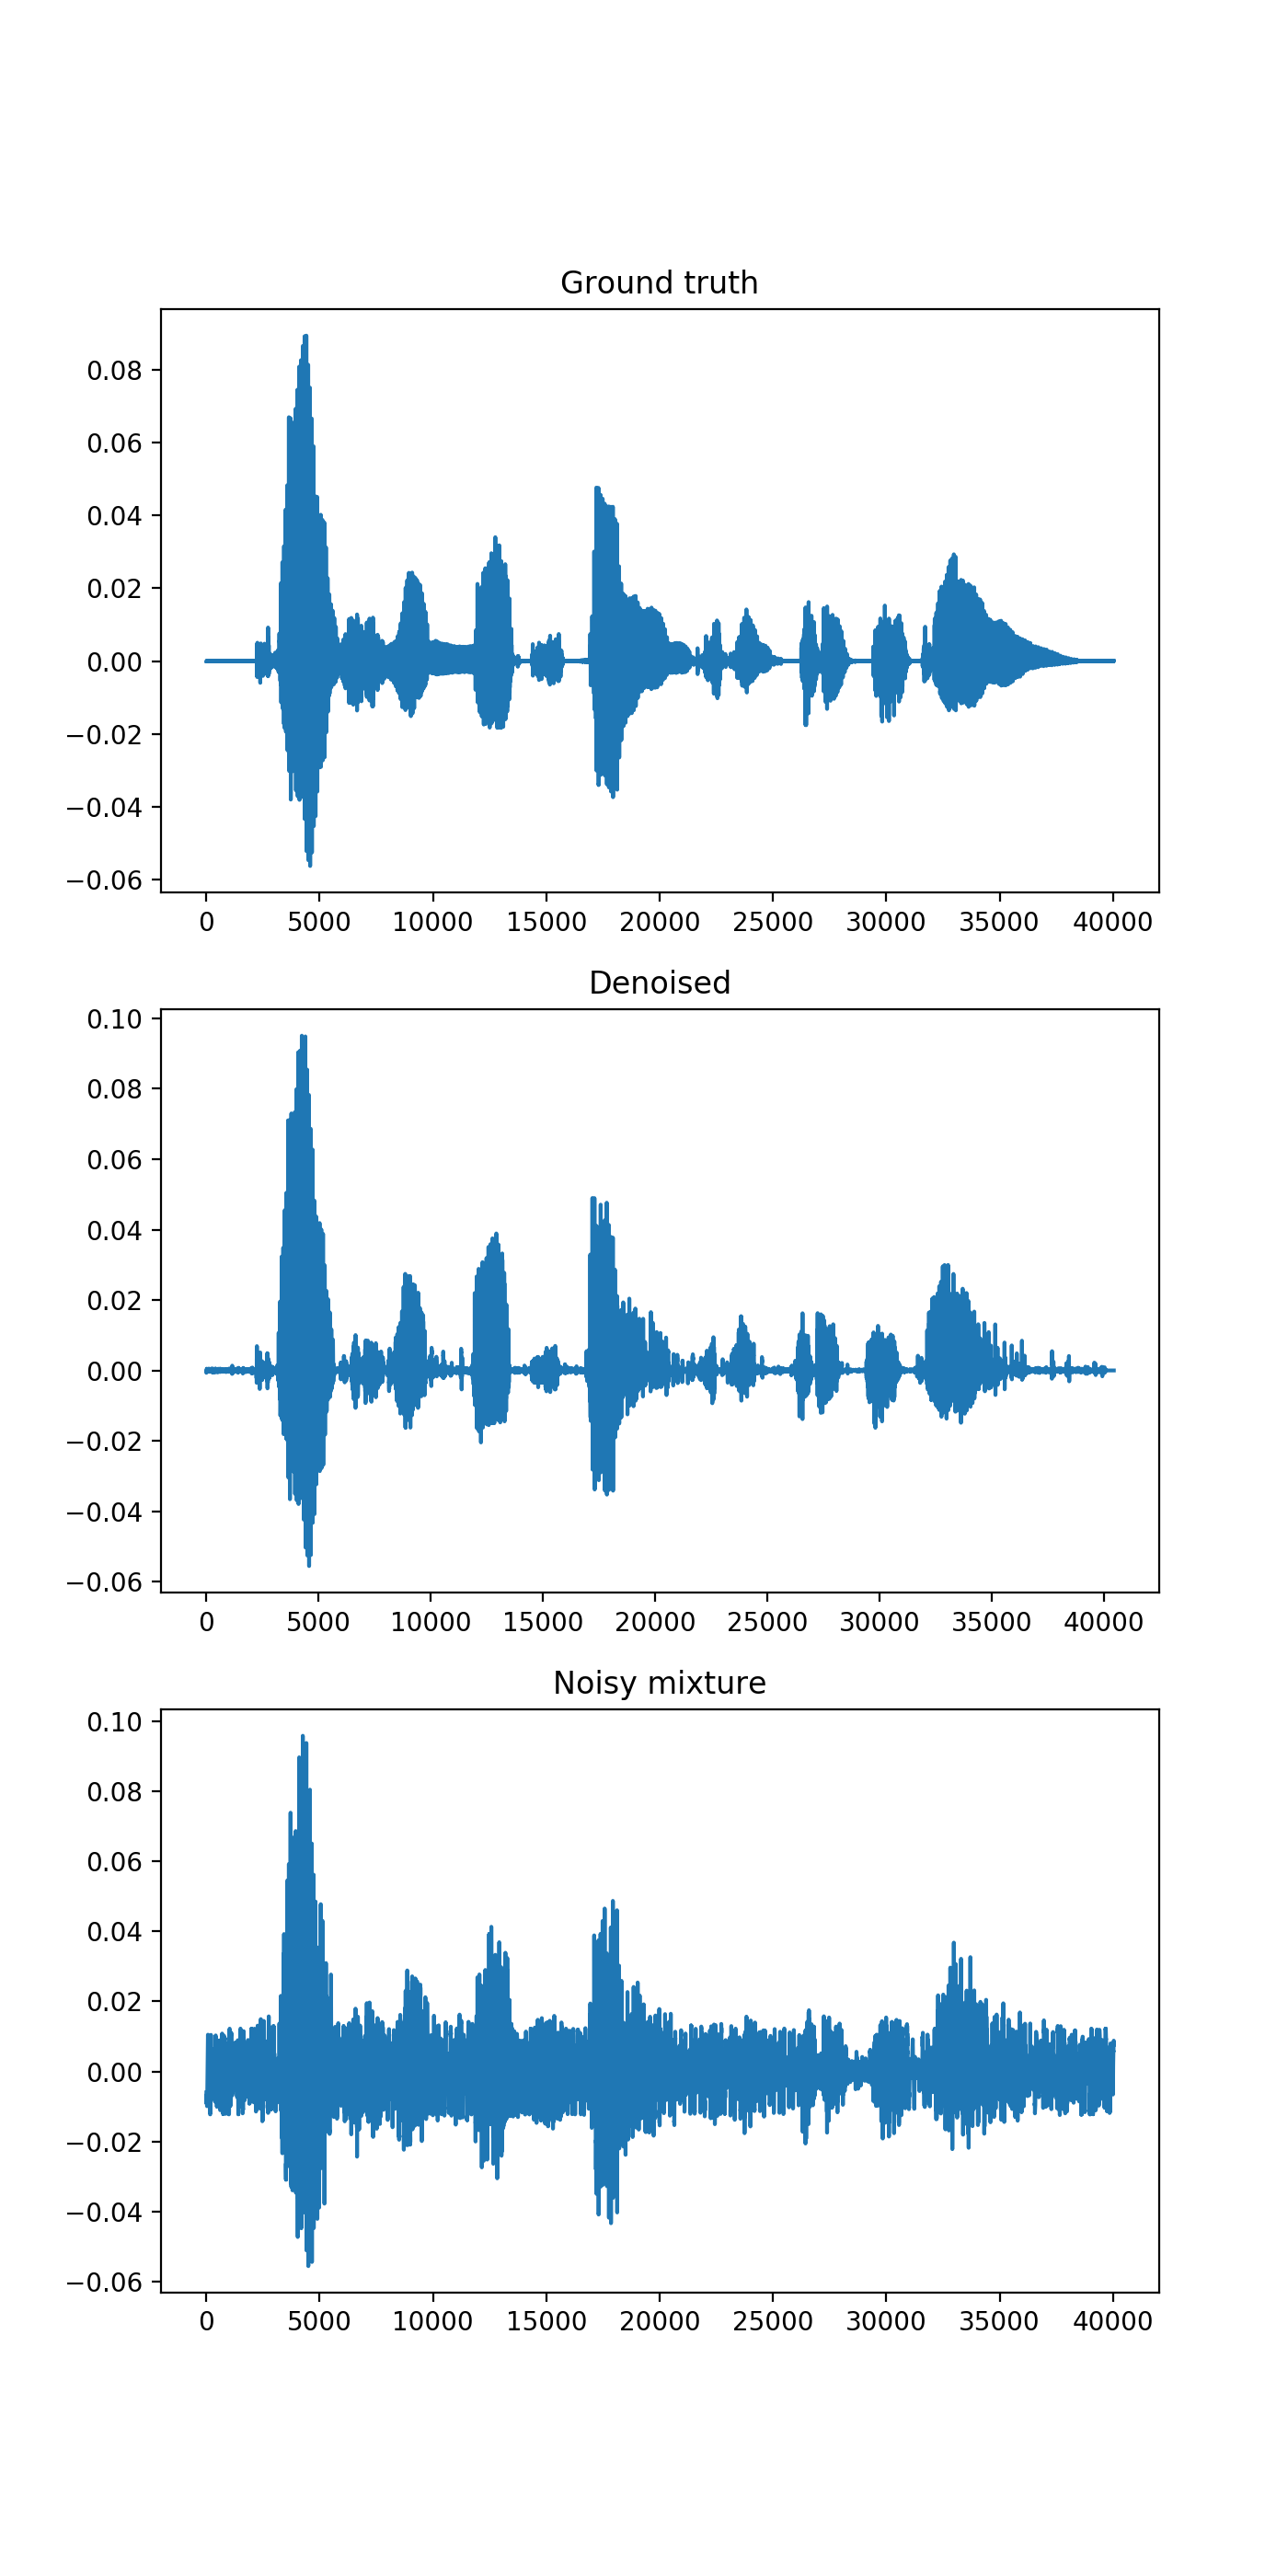

In [33]:
%matplotlib notebook
plt.figure(figsize=(7,14))
plt.subplot(3,1,1)
plt.plot(tes[0])
plt.title('Ground truth')
plt.subplot(3,1,2)
plt.plot(tesr)
plt.title('Denoised')
plt.subplot(3,1,3)
plt.plot(tex[0])
plt.title('Noisy mixture')

plt.savefig('densenet.pdf')

(80, 1024) (800, 1024) (80, 1024)


<IPython.core.display.Javascript object>


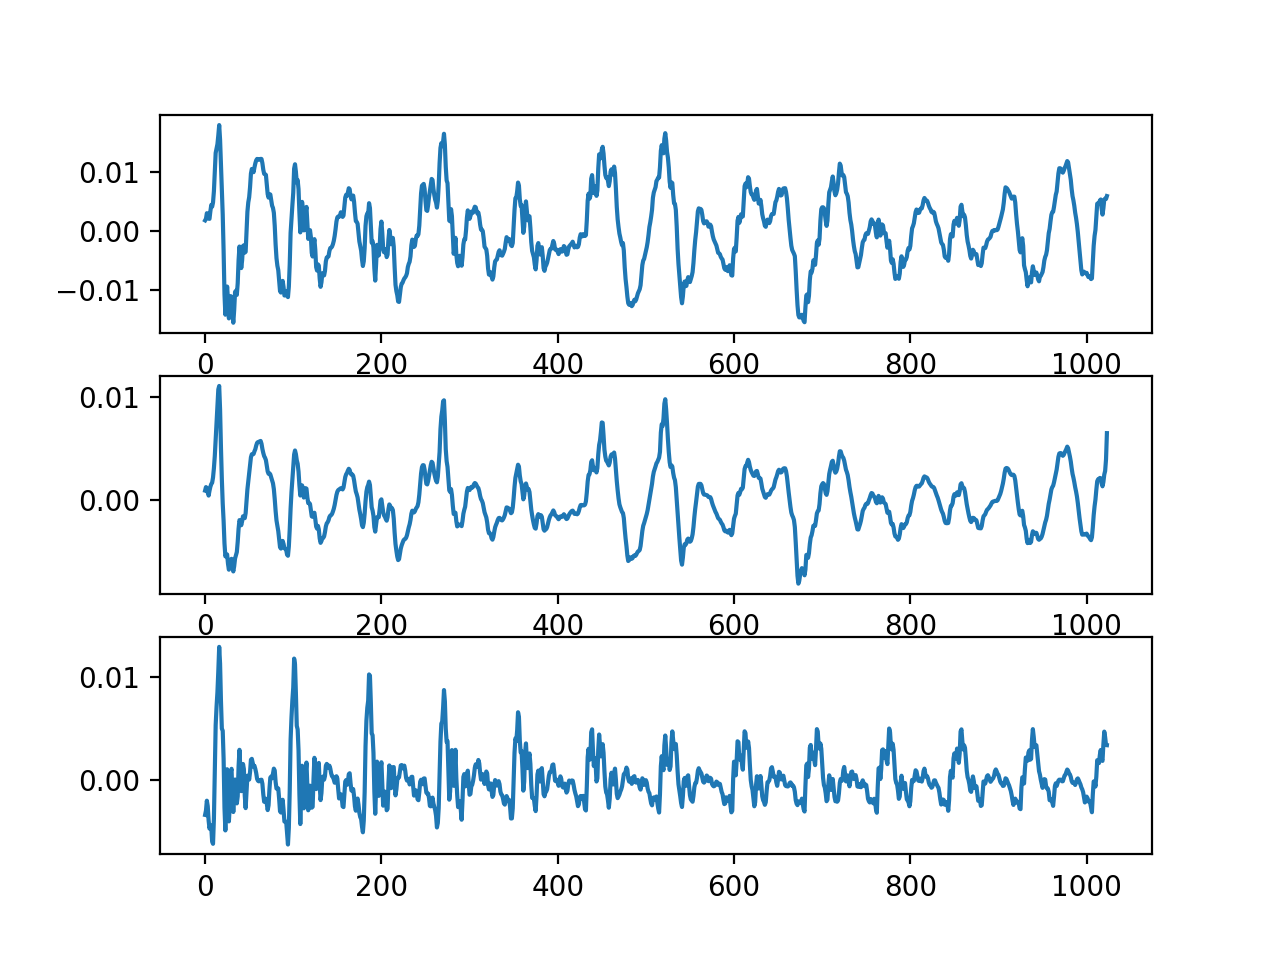

In [157]:
print(teX[0].shape, teSR.shape, teS[0].shape)
plt.figure()
plt.subplot(3,1,1)
plt.plot(teX[0][40,:])
plt.subplot(3,1,2)
plt.plot(teSR[40,:])
plt.subplot(3,1,3)
plt.plot(teS[0][40,:])

In [ ]:
ep: 0	 train error: 19547.125
ep: 1	 train error: 13854.3408203125
ep: 2	 train error: 10930.3720703125
ep: 3	 train error: 11012.728515625
ep: 4	 train error: 10004.7587890625
ep: 5	 train error: 9609.6591796875
ep: 6	 train error: 9529.3740234375
ep: 7	 train error: 9196.611328125
ep: 8	 train error: 9085.8671875
ep: 9	 train error: 9012.64453125
ep: 10	 train error: 8943.2919921875
ep: 11	 train error: 8902.4853515625
ep: 12	 train error: 8857.4931640625
ep: 13	 train error: 8806.2890625
ep: 14	 train error: 8759.607421875
ep: 15	 train error: 8711.517578125
ep: 16	 train error: 8662.115234375
ep: 17	 train error: 8630.5888671875
ep: 18	 train error: 8596.3525390625
ep: 19	 train error: 8572.1181640625
ep: 20	 train error: 8545.310546875

In [18]:
def SDR(s,sr):
    eps=1e-20
    ml=np.minimum(len(s), len(sr))
    s=s[:ml]
    sr=sr[:ml]
    return ml, 10*np.log10(np.sum(s**2)/(np.sum((s-sr)**2)+eps)+eps)

def GRU_SS_test_SDR(model, data, Y, s):
    model.eval()
    ml=np.zeros(len(data))
    SDRlist=np.zeros(len(data))
    err=0.
    for i in range(0,len(data),bs):
        mbc=np.transpose(np.asarray(data[i:i+bs]), (2,0,1))
        mb=Variable(torch.cuda.FloatTensor(np.abs(mbc)))
        teYh=model(mb)
        mbY=Variable(torch.cuda.FloatTensor(np.transpose(np.array(Y[i:i+bs]), (2,0,1))))        
        err+=torch.sum(-mbY*torch.log(teYh+eps)-(1-mbY)*torch.log(1-teYh+eps))\
            .data.cpu().numpy()
#         err+=torch.sum(-((mbY+1)*.5)*torch.log((teYh+1)*.5+eps)-(1-(mbY+1)*.5)*torch.log(1-(teYh+1)*.5+eps))\
#             .data.cpu().numpy()
        teSR=np.transpose(mbc*np.float32(teYh.data.cpu().numpy()), (2,0,1))
        for j in range(teSR.shape[2]):
            tesr=librosa.istft(teSR[:,:,j], hop_length=256)
            ml[i+j], SDRlist[i+j]=SDR(s[i+j], tesr)
    return err, np.sum(ml*SDRlist/np.sum(ml))




In [19]:
lookback=30
Hcnn=50
Hrnn=1024
# nL=2
bs=10
eps=1e-20
model=SS1dCNN_GRU(Hcnn, Hrnn, 513).cuda()
optimizer= torch.optim.Adam(model.parameters(), lr=0.001)#, betas=[0.9, 0.999])
maxEpoch=200
errt=np.zeros(maxEpoch, dtype=np.float32)

for epoch in range(maxEpoch):    
    model.train()
    for i in range(0,len(trX),bs):
        mb=Variable(torch.cuda.FloatTensor((np.abs(np.transpose(np.asarray(trX[i:i+bs]), (2,0,1))))), requires_grad=False)
        mbY=Variable(torch.cuda.FloatTensor((np.transpose(np.array(trY[i:i+bs]), (2,0,1)))), requires_grad=False)
#         trYh=model(mb)
#         err=torch.sum(-mbY*torch.log(trYh+eps)-(1-mbY)*torch.log(1-trYh+eps))        
# #         err=torch.sum(-((mbY+1)*.5)*torch.log((trYh+1)*.5+eps)\
# #                       -(1-(mbY+1)*.5)*torch.log(1-(trYh+1)*.5+eps))

# # #         err=torch.sum((mbY-trYh)**2) # MSE
#         errt[epoch]+=err.data.cpu().numpy()
#         optimizer.zero_grad()
#         err.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(),.0001)
#         optimizer.step()
        T=mb.shape[0]
        for j in range(0,T-lookback+1, lookback):
            trYh=model(mb[j:j+lookback,:,:])
#             err=torch.sum(-((mbY[j:j+lookback,:,:]+1)*.5)*torch.log((trYh[:,:,:]+1)*.5+eps)\
#                           -(1-(mbY[j:j+lookback,:,:]+1)*.5)*torch.log(1-(trYh[:,:,:]+1)*.5+eps))
            err=torch.sum(-mbY[j:j+lookback,:,:]*torch.log(trYh[:,:,:]+eps)\
                          -(1-mbY[j:j+lookback,:,:])*torch.log(1-trYh[:,:,:]+eps))

            errt[epoch]+=err.data.cpu().numpy()
            optimizer.zero_grad()
            err.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(model.parameters(),.0001)
            optimizer.step()
    print('ep: {}\t train error: {}'.format(epoch, errt[epoch]))
#     print(GRU_SS_test_SDR(model1R, vX, vY, vs)) # validation
    print(GRU_SS_test_SDR(model, teX, teY, tes)) # test    


ep: 0	 train error: 442534464.0
(107025367.09375, 10.80925876207812)
ep: 1	 train error: 396530784.0
(97453724.78125, 11.367868058825263)
ep: 2	 train error: 380207712.0
(95902572.859375, 11.588880804660853)
ep: 3	 train error: 369430976.0
(92638800.5625, 11.720011735779224)
ep: 4	 train error: 361089472.0
(91262574.0, 11.832744477050774)
ep: 5	 train error: 354660064.0
(90296050.21875, 11.943620168891115)
ep: 6	 train error: 349610752.0
(89653971.40625, 11.987253495605499)
ep: 7	 train error: 345784448.0
(88563336.03125, 12.007654068400697)
ep: 8	 train error: 342068064.0
(88936361.84375, 11.971084194998527)
ep: 9	 train error: 339169856.0
(88997387.125, 11.930387073058824)
ep: 10	 train error: 336519712.0
(88795766.40625, 12.023692793061624)
ep: 11	 train error: 334449664.0
(89883623.765625, 11.99760887448123)
ep: 12	 train error: 332605792.0
(89477966.21875, 11.986221131612947)
ep: 13	 train error: 330863072.0
(89308655.1875, 12.017046555638249)
ep: 14	 train error: 329292480.0
(885

KeyboardInterrupt: 

In [11]:
class SS1dCNN_ResNet_Block(nn.Module):
    def __init__(self, H1, H2, K):
        super().__init__()

        padSize=np.int(np.floor(K/2))
        
        self.conv0 = nn.Conv1d(in_channels=1, out_channels=H1, kernel_size=K, padding=padSize, bias=False)
        self.bn0 = nn.BatchNorm1d(H1)
        self.conv1 = nn.Conv1d(in_channels=H1, out_channels=H2, kernel_size=K, padding=padSize, bias=False)
        self.bn1 = nn.BatchNorm1d(H2)
        self.conv2 = nn.Conv1d(in_channels=H2, out_channels=H1, kernel_size=K, padding=padSize, bias=False)
        self.bn2 = nn.BatchNorm1d(H1)
        self.conv3 = nn.Conv1d(in_channels=H1, out_channels=H2, kernel_size=K, padding=padSize, bias=False)
        self.bn3 = nn.BatchNorm1d(H2)
        self.conv4 = nn.Conv1d(in_channels=H2, out_channels=H1, kernel_size=K, padding=padSize, bias=False)
        self.bn4 = nn.BatchNorm1d(H1)
        self.conv5 = nn.Conv1d(in_channels=H1, out_channels=H2, kernel_size=K, padding=padSize, bias=False)
        self.bn5 = nn.BatchNorm1d(H2)
        self.conv6 = nn.Conv1d(in_channels=H2, out_channels=H1, kernel_size=K, padding=padSize, bias=False)
        self.bn6 = nn.BatchNorm1d(H1)
        self.conv7 = nn.Conv1d(in_channels=H1, out_channels=H2, kernel_size=K, padding=padSize, bias=False)
        self.bn7 = nn.BatchNorm1d(H2)
        self.conv8 = nn.Conv1d(in_channels=H2, out_channels=H1, kernel_size=K, padding=padSize, bias=False)
        self.bn8 = nn.BatchNorm1d(H1)
        self.conv9 = nn.Conv1d(in_channels=H1, out_channels=H2, kernel_size=K, padding=padSize, bias=False)
        self.bn9 = nn.BatchNorm1d(H2)
        self.conv10 = nn.Conv1d(in_channels=H2, out_channels=H1, kernel_size=K, padding=padSize, bias=False)
        self.bn10 = nn.BatchNorm1d(H1)
        self.conv11 = nn.Conv1d(in_channels=H1, out_channels=H2, kernel_size=K, padding=padSize, bias=False)        
        self.bn11 = nn.BatchNorm1d(H2)
        self.conv12 = nn.Conv1d(in_channels=H2, out_channels=H1, kernel_size=K, padding=padSize, bias=False)
        self.bn12 = nn.BatchNorm1d(H1)
        self.conv13 = nn.Conv1d(in_channels=H1, out_channels=H2, kernel_size=K, padding=padSize, bias=False)
        self.bn13 = nn.BatchNorm1d(H2)
        self.conv14 = nn.Conv1d(in_channels=H2, out_channels=H1, kernel_size=K, padding=padSize, bias=False)
        self.bn14 = nn.BatchNorm1d(H1)
        self.conv15 = nn.Conv1d(in_channels=H1, out_channels=H2, kernel_size=K, padding=padSize, bias=False)
        self.bn15 = nn.BatchNorm1d(H2)
        self.conv16 = nn.Conv1d(in_channels=H2, out_channels=H1, kernel_size=K, padding=padSize, bias=False)
        self.bn16 = nn.BatchNorm1d(H1)
        self.conv17 = nn.Conv1d(in_channels=H1, out_channels=H2, kernel_size=K, padding=padSize, bias=False)
        self.bn17 = nn.BatchNorm1d(H2)
        self.conv18 = nn.Conv1d(in_channels=H2, out_channels=H1, kernel_size=K, padding=padSize, bias=False)
        self.bn18 = nn.BatchNorm1d(H1)
        self.conv19 = nn.Conv1d(in_channels=H1, out_channels=H2, kernel_size=K, padding=padSize, bias=False)
        self.bn19 = nn.BatchNorm1d(H2)
        self.conv20 = nn.Conv1d(in_channels=H2, out_channels=H1, kernel_size=K, padding=padSize, bias=False)
        self.bn20 = nn.BatchNorm1d(H1)
        self.conv21 = nn.Conv1d(in_channels=H1, out_channels=1, kernel_size=K, padding=padSize)        
        
        nn.init.kaiming_normal_(self.conv0.weight)
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.kaiming_normal_(self.conv3.weight)
        nn.init.kaiming_normal_(self.conv4.weight)
        nn.init.kaiming_normal_(self.conv5.weight)
        nn.init.kaiming_normal_(self.conv6.weight)
        nn.init.kaiming_normal_(self.conv7.weight)
        nn.init.kaiming_normal_(self.conv8.weight)
        nn.init.kaiming_normal_(self.conv9.weight)
        nn.init.kaiming_normal_(self.conv10.weight)
        nn.init.kaiming_normal_(self.conv11.weight)
        nn.init.kaiming_normal_(self.conv12.weight)
        nn.init.kaiming_normal_(self.conv13.weight)
        nn.init.kaiming_normal_(self.conv14.weight)
        nn.init.kaiming_normal_(self.conv15.weight)
        nn.init.kaiming_normal_(self.conv16.weight)
        nn.init.kaiming_normal_(self.conv17.weight)
        nn.init.kaiming_normal_(self.conv18.weight)
        nn.init.kaiming_normal_(self.conv19.weight)
        nn.init.kaiming_normal_(self.conv20.weight)
        nn.init.kaiming_normal_(self.conv21.weight)        
#         nn.init.xavier_normal_(self.conv0.weight)
#         nn.init.xavier_normal_(self.conv1.weight)
#         nn.init.xavier_normal_(self.conv2.weight)
#         nn.init.xavier_normal_(self.conv3.weight)
#         nn.init.xavier_normal_(self.conv4.weight)
#         nn.init.xavier_normal_(self.conv5.weight)        



    def forward(self, h0):    
#         h0=x.view(-1,1,GV_FRAMESIZE)
        h1=F.relu(self.bn0(self.conv0(h0)))
        h2=F.relu(self.bn1(self.conv1(h1)))
        h3=F.relu(self.bn2(self.conv2(h2))+h1)
        h4=F.relu(self.bn3(self.conv3(h3)))
        h5=F.relu(self.bn4(self.conv4(h4)+h3))
        h6=F.relu(self.bn5(self.conv5(h5)))
        h7=F.relu(self.bn6(self.conv6(h6))+h5)
        h8=F.relu(self.bn7(self.conv7(h7)))
        h9=F.relu(self.bn8(self.conv8(h8))+h7)
        h10=F.relu(self.bn9(self.conv9(h9)))
        h11=F.relu(self.bn10(self.conv10(h10))+h9)
        h12=F.relu(self.bn11(self.conv11(h11)))
        h13=F.relu(self.bn12(self.conv12(h12))+h11)
        h14=F.relu(self.bn13(self.conv13(h13)))
        h15=F.relu(self.bn14(self.conv14(h14))+h13)
        h16=F.relu(self.bn15(self.conv15(h15)))
        h17=F.relu(self.bn16(self.conv16(h16))+h15)
        h18=F.relu(self.bn17(self.conv17(h17)))
        h19=F.relu(self.bn18(self.conv18(h18))+h17)        
        h20=F.relu(self.bn19(self.conv19(h19)))        
        h21=F.relu(self.bn20(self.conv20(h20))+h19)                
        o=self.conv21(h21)
        return o

class SS1dCNN_ResNet20(nn.Module):
    def __init__(self, H, K):
        super().__init__()
        self.K=K
        self.H=H  
        padSize=np.int(np.floor(K/2))
        
        self.conv0 = nn.Conv1d(in_channels=1, out_channels=H, kernel_size=K, padding=padSize)
        self.conv1 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv2 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv3 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv4 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv5 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv6 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv7 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv8 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv9 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv10 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv11 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)        
        self.conv12 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv13 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv14 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv15 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv16 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv17 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv18 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv19 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv20 = nn.Conv1d(in_channels=H, out_channels=1, kernel_size=K, padding=padSize)        
        
        nn.init.kaiming_normal_(self.conv0.weight)
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.kaiming_normal_(self.conv3.weight)
        nn.init.kaiming_normal_(self.conv4.weight)
        nn.init.kaiming_normal_(self.conv5.weight)
        nn.init.kaiming_normal_(self.conv6.weight)
        nn.init.kaiming_normal_(self.conv7.weight)
        nn.init.kaiming_normal_(self.conv8.weight)
        nn.init.kaiming_normal_(self.conv9.weight)
        nn.init.kaiming_normal_(self.conv10.weight)
        nn.init.kaiming_normal_(self.conv11.weight)
        nn.init.kaiming_normal_(self.conv12.weight)
        nn.init.kaiming_normal_(self.conv13.weight)
        nn.init.kaiming_normal_(self.conv14.weight)
        nn.init.kaiming_normal_(self.conv15.weight)
        nn.init.kaiming_normal_(self.conv16.weight)
        nn.init.kaiming_normal_(self.conv17.weight)
        nn.init.kaiming_normal_(self.conv18.weight)
        nn.init.kaiming_normal_(self.conv19.weight)
        nn.init.kaiming_normal_(self.conv20.weight)
#         nn.init.xavier_normal_(self.conv0.weight)
#         nn.init.xavier_normal_(self.conv1.weight)
#         nn.init.xavier_normal_(self.conv2.weight)
#         nn.init.xavier_normal_(self.conv3.weight)
#         nn.init.xavier_normal_(self.conv4.weight)
#         nn.init.xavier_normal_(self.conv5.weight)        



    def forward(self, h0):    
#         h0=x.view(-1,1,GV_FRAMESIZE)
        h1=F.relu(self.conv0(h0))
        h2=F.relu(self.conv1(h1)+h1)
        h3=F.relu(self.conv2(h2)+h2)
        h4=F.relu(self.conv3(h3)+h3)
        h5=F.relu(self.conv4(h4)+h4)
        h6=F.relu(self.conv5(h5)+h5)
        h7=F.relu(self.conv6(h6)+h6)
        h8=F.relu(self.conv7(h7)+h7)
        h9=F.relu(self.conv8(h8)+h8)
        h10=F.relu(self.conv9(h9)+h9)
        h11=F.relu(self.conv10(h10)+h10)
        h12=F.relu(self.conv11(h11)+h11)
        h13=F.relu(self.conv12(h12)+h12)
        h14=F.relu(self.conv13(h13)+h13)
        h15=F.relu(self.conv14(h14)+h14)
        h16=F.relu(self.conv15(h15)+h15)
        h17=F.relu(self.conv16(h16)+h16)
        h18=F.relu(self.conv17(h17)+h17)
        h19=F.relu(self.conv18(h18)+h18)        
        h20=F.relu(self.conv19(h19)+h19)        
        o=self.conv20(h20)
        return o
    
class SS1dCNN_ResNet10(nn.Module):
    def __init__(self, H, K):
        super().__init__()
        self.K=K
        self.H=H  
        padSize=np.int(np.floor(K/2))
        
        self.conv0 = nn.Conv1d(in_channels=1, out_channels=H, kernel_size=K, padding=padSize)
        self.conv1 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv2 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv3 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv4 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv5 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv6 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv7 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv8 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv9 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv10 = nn.Conv1d(in_channels=H, out_channels=1, kernel_size=K, padding=padSize)        
        
        nn.init.kaiming_normal_(self.conv0.weight)
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.kaiming_normal_(self.conv3.weight)
        nn.init.kaiming_normal_(self.conv4.weight)
        nn.init.kaiming_normal_(self.conv5.weight)
        nn.init.kaiming_normal_(self.conv6.weight)
        nn.init.kaiming_normal_(self.conv7.weight)
        nn.init.kaiming_normal_(self.conv8.weight)
        nn.init.kaiming_normal_(self.conv9.weight)
        nn.init.kaiming_normal_(self.conv10.weight)


    def forward(self, h0):    
#         h0=x.view(-1,1,GV_FRAMESIZE)
        h1=F.relu(self.conv0(h0))
        h2=F.relu(self.conv1(h1)+h1)
        h3=F.relu(self.conv2(h2)+h2)
        h4=F.relu(self.conv3(h3)+h3)
        h5=F.relu(self.conv4(h4)+h4)
        h6=F.relu(self.conv5(h5)+h5)
        h7=F.relu(self.conv6(h6)+h6)
        h8=F.relu(self.conv7(h7)+h7)
        h9=F.relu(self.conv8(h8)+h8)
        h10=F.relu(self.conv9(h9)+h9)
        o=self.conv10(h10)
        return o    


class SS1dCNN_Dense(nn.Module):
    def __init__(self, H, Kl, Ks):
        super().__init__()
        padSizeL=np.int(np.floor(Kl/2))
        padSizeS=np.int(np.floor(Ks/2))        
        
        self.conv0 = nn.Conv1d(in_channels=1, out_channels=H, kernel_size=Kl, padding=padSizeL)
        self.conv1 = nn.Conv1d(in_channels=H+1, out_channels=H, kernel_size=Ks, padding=padSizeS)
        self.conv2 = nn.Conv1d(in_channels=H*2+1, out_channels=H, kernel_size=Ks, padding=padSizeS)
        self.conv3 = nn.Conv1d(in_channels=H*3+1, out_channels=H, kernel_size=Ks, padding=padSizeS)
        self.conv4 = nn.Conv1d(in_channels=H*4+1, out_channels=H, kernel_size=Ks, padding=padSizeS)
        self.conv5 = nn.Conv1d(in_channels=H*5+1, out_channels=1, kernel_size=Ks, padding=padSizeS)
        
#         nn.init.kaiming_normal_(self.conv0.weight)
#         nn.init.kaiming_normal_(self.conv1.weight)
#         nn.init.kaiming_normal_(self.conv2.weight)
#         nn.init.kaiming_normal_(self.conv3.weight)
#         nn.init.kaiming_normal_(self.conv4.weight)
#         nn.init.kaiming_normal_(self.conv5.weight)        
        nn.init.xavier_normal_(self.conv0.weight, gain=2.)
        nn.init.xavier_normal_(self.conv1.weight, gain=2.)
        nn.init.xavier_normal_(self.conv2.weight, gain=1.)
        nn.init.xavier_normal_(self.conv3.weight, gain=2./3.)
        nn.init.xavier_normal_(self.conv4.weight, gain=2./4.)
        nn.init.xavier_normal_(self.conv5.weight, gain=2./5.)        

    def forward(self, h0):    
#         h0=x.view(-1,1,GV_FRAMESIZE)
        h1=F.relu(self.conv0(h0))
        h2=F.relu(self.conv1(torch.cat((h0,h1), dim=1)))
        h3=F.relu(self.conv2(torch.cat((h0,h1,h2), dim=1)))
        h4=F.relu(self.conv3(torch.cat((h0,h1,h2,h3), dim=1)))
        h5=F.relu(self.conv4(torch.cat((h0,h1,h2,h3,h4), dim=1)))
        o=self.conv5(torch.cat((h0,h1,h2,h3,h4,h5), dim=1))
        return o
    
class SS1dCNN_DenseBlock2(nn.Module):
    def __init__(self, H, Kl, Ks):
        super().__init__()
        padSizeL=np.int(np.floor(Kl/2))
        padSizeS=np.int(np.floor(Ks/2))
        
        self.convIn = nn.Conv1d(in_channels=1, out_channels=H, kernel_size=Kl, padding=padSizeL)
        
        self.conv11 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=Ks, padding=padSizeS)
        self.conv12 = nn.Conv1d(in_channels=H*2, out_channels=H, kernel_size=Ks, padding=padSizeS)
        self.conv13 = nn.Conv1d(in_channels=H*3, out_channels=H, kernel_size=Ks, padding=padSizeS)
        self.conv14 = nn.Conv1d(in_channels=H*4, out_channels=H, kernel_size=Ks, padding=padSizeS)
        self.conv15 = nn.Conv1d(in_channels=H*5, out_channels=H, kernel_size=Ks, padding=padSizeS)

        self.conv21 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=Ks, padding=padSizeS)
        self.conv22 = nn.Conv1d(in_channels=H*2, out_channels=H, kernel_size=Ks, padding=padSizeS)
        self.conv23 = nn.Conv1d(in_channels=H*3, out_channels=H, kernel_size=Ks, padding=padSizeS)
        self.conv24 = nn.Conv1d(in_channels=H*4, out_channels=H, kernel_size=Ks, padding=padSizeS)
        self.conv25 = nn.Conv1d(in_channels=H*5, out_channels=H, kernel_size=Ks, padding=padSizeS)        

        self.convOut = nn.Conv1d(in_channels=H, out_channels=1, kernel_size=Kl, padding=padSizeL)        
        
        nn.init.kaiming_normal_(self.convIn.weight)
        nn.init.kaiming_normal_(self.conv11.weight)
        nn.init.kaiming_normal_(self.conv12.weight)
        nn.init.kaiming_normal_(self.conv13.weight)
        nn.init.kaiming_normal_(self.conv14.weight)
        nn.init.kaiming_normal_(self.conv15.weight)        
        nn.init.kaiming_normal_(self.conv21.weight)
        nn.init.kaiming_normal_(self.conv22.weight)
        nn.init.kaiming_normal_(self.conv23.weight)
        nn.init.kaiming_normal_(self.conv24.weight)
        nn.init.kaiming_normal_(self.conv25.weight)
        nn.init.kaiming_normal_(self.convOut.weight)        

    def forward(self, h0):    
#         h0=x.view(-1,1,GV_FRAMESIZE)
        h11=F.relu(self.convIn(h0))
        h12=F.relu(self.conv11(h11))
        h13=F.relu(self.conv12(torch.cat((h11,h12), dim=1)))
        h14=F.relu(self.conv13(torch.cat((h11,h12,h13), dim=1)))
        h15=F.relu(self.conv14(torch.cat((h11,h12,h13,h14), dim=1)))
        h21=F.relu(self.conv15(torch.cat((h11,h12,h13,h14,h15), dim=1)))
        h22=F.relu(self.conv21(h21))
        h23=F.relu(self.conv22(torch.cat((h21,h22), dim=1)))
        h24=F.relu(self.conv23(torch.cat((h21,h22,h23), dim=1)))
        h25=F.relu(self.conv24(torch.cat((h21,h22,h23,h24), dim=1)))
        ho=F.relu(self.conv25(torch.cat((h21,h22,h23,h24,h25), dim=1)))
        o=self.convOut(ho)
        return o
    
class SS1dCNN_DenseBlock3(nn.Module):
    def __init__(self, H, K):
        super().__init__()
        self.K=K
        self.H=H
        padSize=np.int(np.floor(K/2))
        
        self.convIn = nn.Conv1d(in_channels=1, out_channels=H, kernel_size=K, padding=padSize)
        
        self.conv11 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv12 = nn.Conv1d(in_channels=H*2, out_channels=H, kernel_size=K, padding=padSize)
        self.conv13 = nn.Conv1d(in_channels=H*3, out_channels=H, kernel_size=K, padding=padSize)
        self.conv14 = nn.Conv1d(in_channels=H*4, out_channels=H, kernel_size=K, padding=padSize)
        self.conv15 = nn.Conv1d(in_channels=H*5, out_channels=H, kernel_size=K, padding=padSize)

        self.conv21 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv22 = nn.Conv1d(in_channels=H*2, out_channels=H, kernel_size=K, padding=padSize)
        self.conv23 = nn.Conv1d(in_channels=H*3, out_channels=H, kernel_size=K, padding=padSize)
        self.conv24 = nn.Conv1d(in_channels=H*4, out_channels=H, kernel_size=K, padding=padSize)
        self.conv25 = nn.Conv1d(in_channels=H*5, out_channels=H, kernel_size=K, padding=padSize)        

        self.conv31 = nn.Conv1d(in_channels=H, out_channels=H, kernel_size=K, padding=padSize)
        self.conv32 = nn.Conv1d(in_channels=H*2, out_channels=H, kernel_size=K, padding=padSize)
        self.conv33 = nn.Conv1d(in_channels=H*3, out_channels=H, kernel_size=K, padding=padSize)
        self.conv34 = nn.Conv1d(in_channels=H*4, out_channels=H, kernel_size=K, padding=padSize)
        self.conv35 = nn.Conv1d(in_channels=H*5, out_channels=H, kernel_size=K, padding=padSize)                

        self.convOut = nn.Conv1d(in_channels=H, out_channels=1, kernel_size=K, padding=padSize)        
        
        nn.init.kaiming_normal_(self.convIn.weight)
        nn.init.kaiming_normal_(self.conv11.weight)
        nn.init.kaiming_normal_(self.conv12.weight)
        nn.init.kaiming_normal_(self.conv13.weight)
        nn.init.kaiming_normal_(self.conv14.weight)
        nn.init.kaiming_normal_(self.conv15.weight)        
        nn.init.kaiming_normal_(self.conv21.weight)
        nn.init.kaiming_normal_(self.conv22.weight)
        nn.init.kaiming_normal_(self.conv23.weight)
        nn.init.kaiming_normal_(self.conv24.weight)
        nn.init.kaiming_normal_(self.conv25.weight)
        nn.init.kaiming_normal_(self.conv31.weight)
        nn.init.kaiming_normal_(self.conv32.weight)
        nn.init.kaiming_normal_(self.conv33.weight)
        nn.init.kaiming_normal_(self.conv34.weight)
        nn.init.kaiming_normal_(self.conv35.weight)
        nn.init.kaiming_normal_(self.convOut.weight)        

    def forward(self, h0):    
#         h0=x.view(-1,1,GV_FRAMESIZE)
        h11=F.relu(self.convIn(h0))
        h12=F.relu(self.conv11(h11))
        h13=F.relu(self.conv12(torch.cat((h11,h12), dim=1)))
        h14=F.relu(self.conv13(torch.cat((h11,h12,h13), dim=1)))
        h15=F.relu(self.conv14(torch.cat((h11,h12,h13,h14), dim=1)))
        h21=F.relu(self.conv15(torch.cat((h11,h12,h13,h14,h15), dim=1)))
        h22=F.relu(self.conv21(h21))
        h23=F.relu(self.conv22(torch.cat((h21,h22), dim=1)))
        h24=F.relu(self.conv23(torch.cat((h21,h22,h23), dim=1)))
        h25=F.relu(self.conv24(torch.cat((h21,h22,h23,h24), dim=1)))
        h31=F.relu(self.conv25(torch.cat((h21,h22,h23,h24,h25), dim=1)))
        h32=F.relu(self.conv31(h31))
        h33=F.relu(self.conv32(torch.cat((h31,h32), dim=1)))
        h34=F.relu(self.conv33(torch.cat((h31,h32,h33), dim=1)))
        h35=F.relu(self.conv34(torch.cat((h31,h32,h33,h34), dim=1)))
        ho=F.relu(self.conv35(torch.cat((h31,h32,h33,h34,h35), dim=1)))
        o=self.convOut(ho)
        return o    
    